Data can be found here: https://www.kaggle.com/datasets/uciml/faulty-steel-plates

# EDA

## Statistics

In [1]:
import io
import contextlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, LeakyReLU
from tensorflow.keras.initializers import GlorotNormal
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
import fttransformer
import ctgan_oversampling
import torch
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

2025-02-19 10:34:36.825579: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 10:34:36.876416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-19 10:34:36.877531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-19 10:34:37.782084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


load and display the dataset

In [2]:
df = pd.read_csv('csv/faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


General infos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} features, while having {df.isnull().sum().sum()} null values.')
print(f'Features have data type {df.dtypes.unique()[0]} and {df.dtypes.unique()[1]}.')

The dataset has 1941 rows and 34 features, while having 0 null values.
Features have data type int64 and float64.


Statistics about the features

In [5]:
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,1941.0,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03
X_Maximum,1941.0,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03
Y_Minimum,1941.0,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07
Y_Maximum,1941.0,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07
Pixels_Areas,1941.0,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05
X_Perimeter,1941.0,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04
Y_Perimeter,1941.0,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1941.0,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07
Minimum_of_Luminosity,1941.0,8.454869e+01,3.213428e+01,0.0000,63.0000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1941.0,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02


Lower the name of the columns

In [6]:
df.columns = map(str.lower, df.columns)

Create a column encoding the anomalies features


In [7]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults'] 
# list of the features of the steel plates
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas'] 
# mapper for the encoding
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} 

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)

# remove troublesome outlier
df.drop(391, inplace = True)

In [8]:
X = df[feat_col]
y = df['anomaly']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
clf = RandomForestClassifier(n_estimators = 100, random_state = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7757731958762887

In [10]:
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feat_col, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 

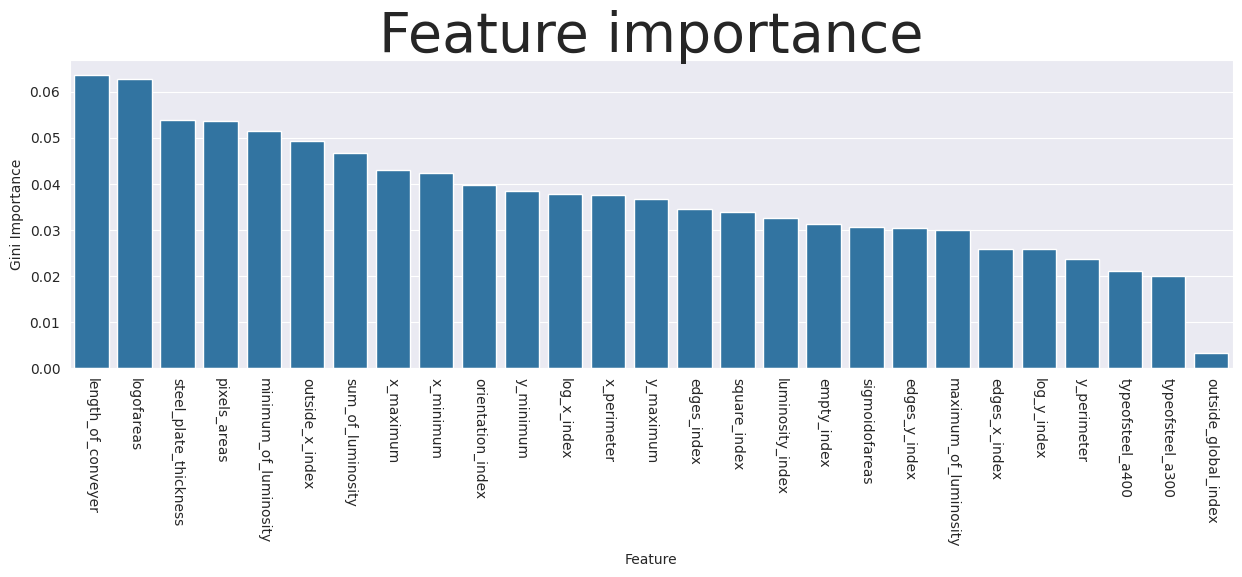

In [11]:
plt.figure(figsize = (15, 4))
plt.title('Feature importance', fontsize = 40)
sns.barplot(feature_imp_df, x = 'Feature', y = 'Gini Importance')
plt.xticks(fontsize = 10, rotation = 270)
plt.show()

## Histograms of the features

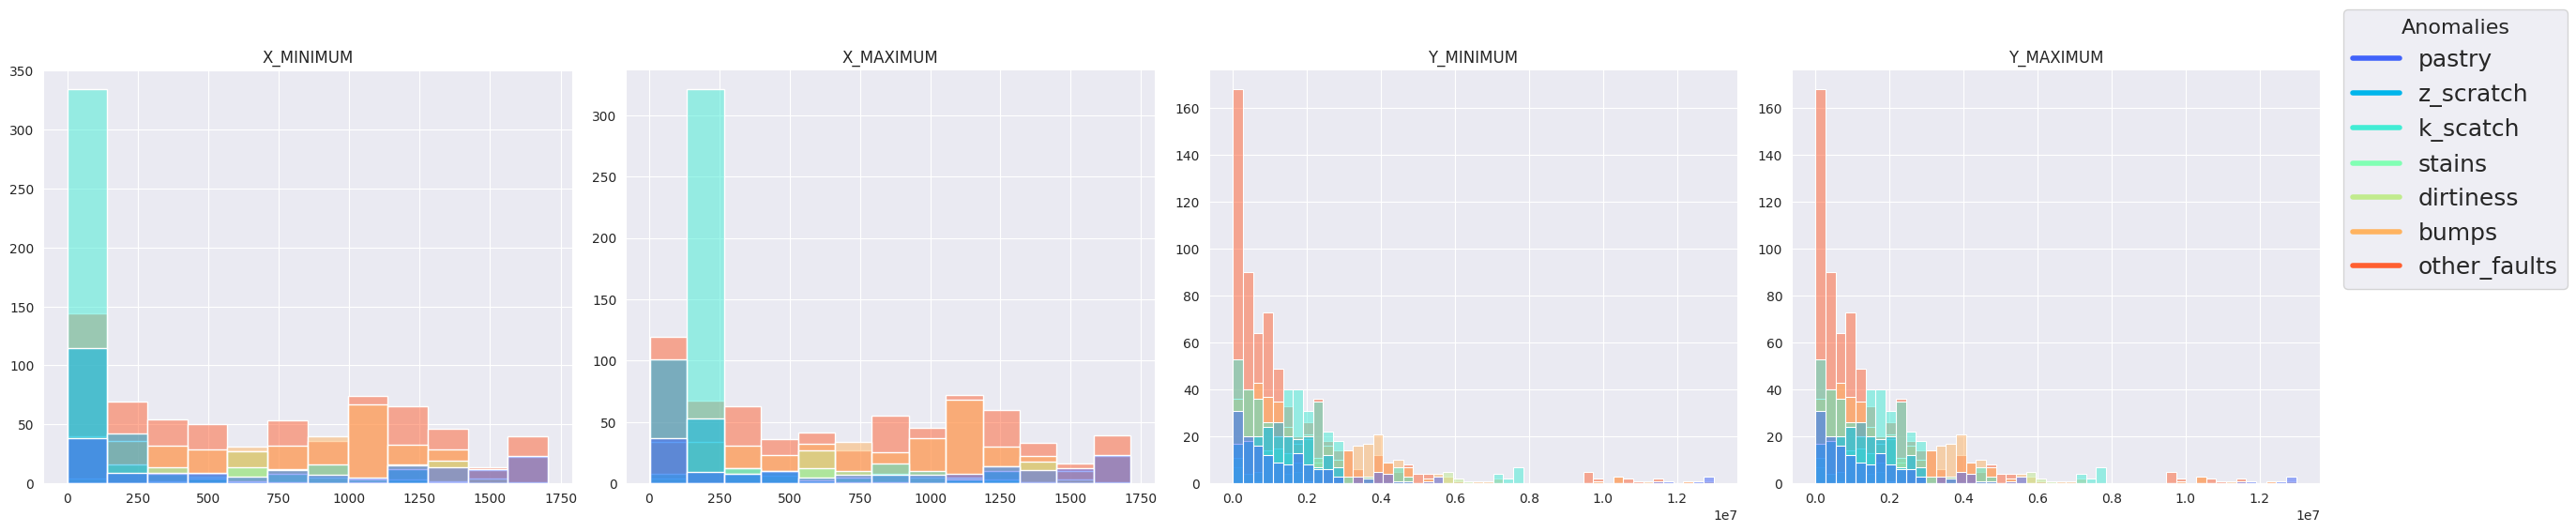

In [12]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

palette_hist = sns.color_palette('rainbow', n_colors = len(df['anomaly'].unique()))
hue_order = df['anomaly'].unique()

colors = sns.color_palette('rainbow', len(target_cols))
handles = [plt.Line2D([0], [0], color = colors[i], lw = 4, label = str(target_cols[i])) for i in range(len(target_cols))]

for index, col in enumerate(feat_col[:4]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

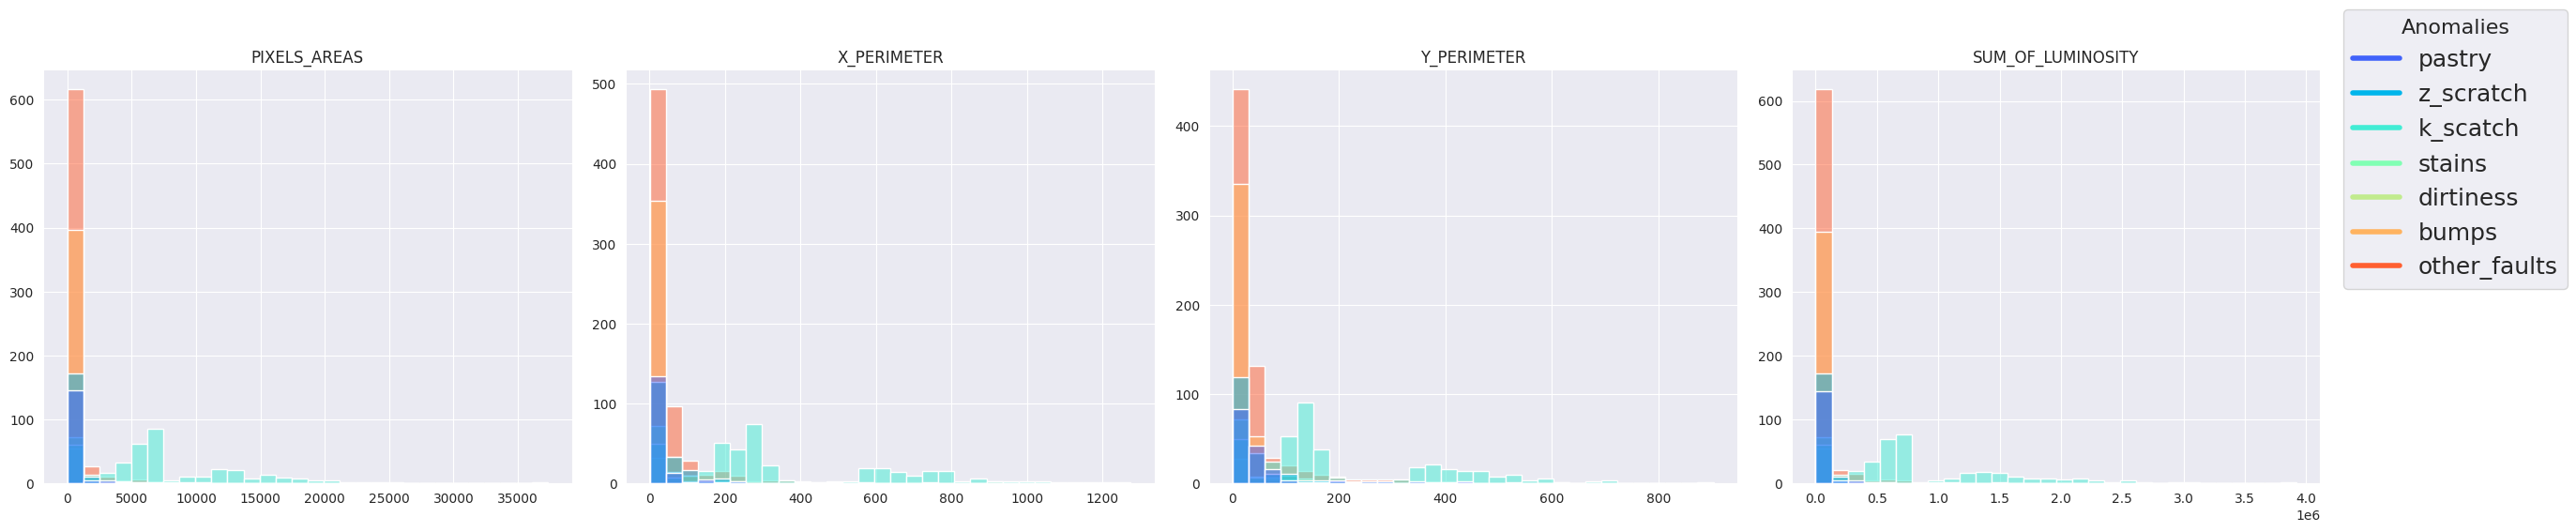

In [13]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False, bins = 30)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('') 

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

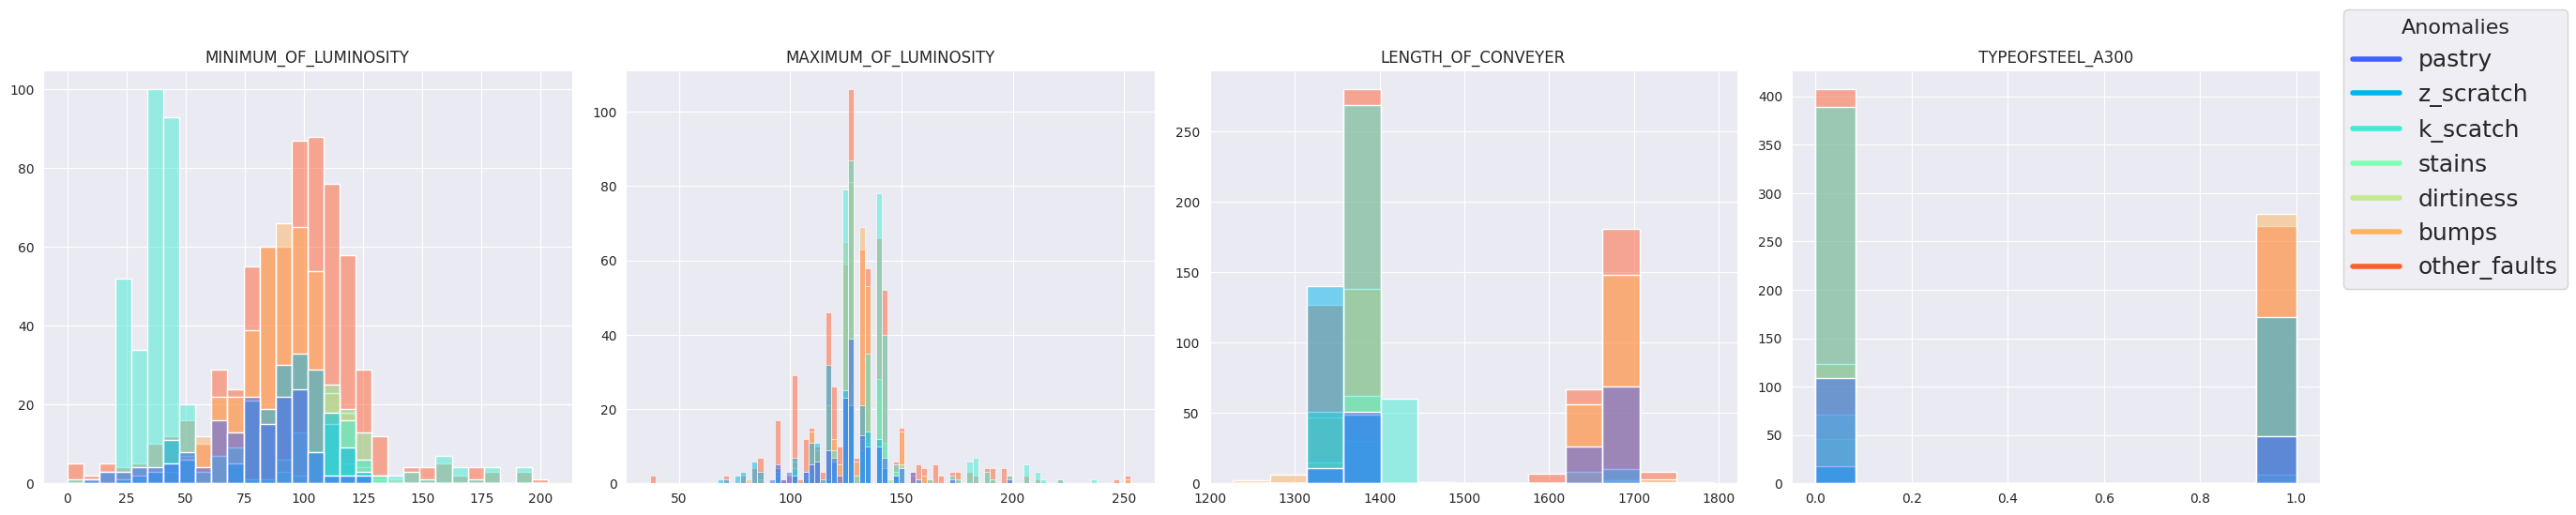

In [14]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

Lenght of conveyer has 2 distinct groups in the histogram, that's why it's an important feature.

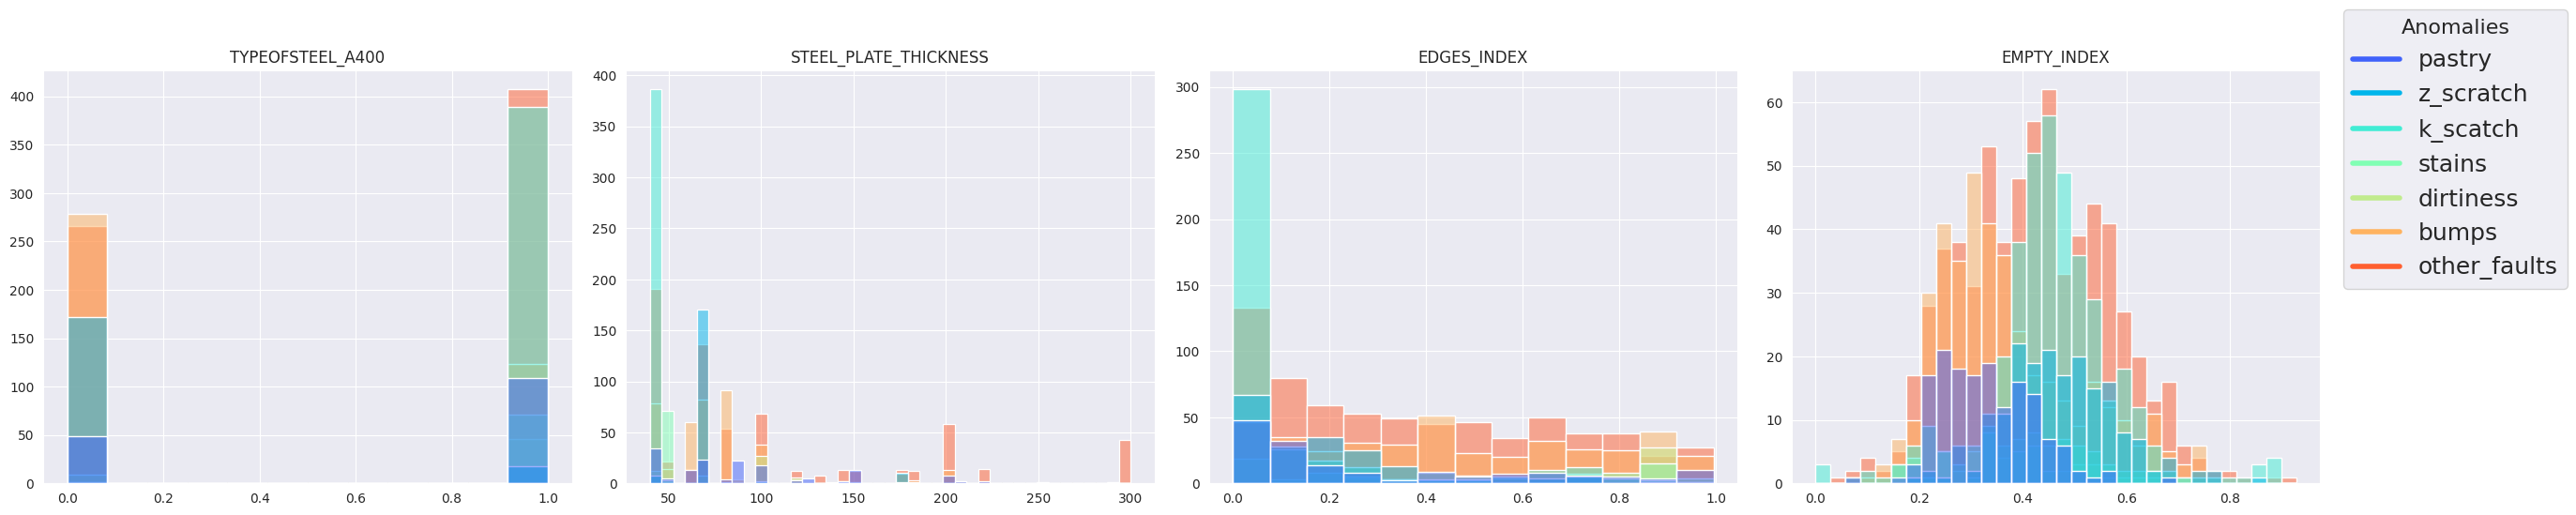

In [15]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

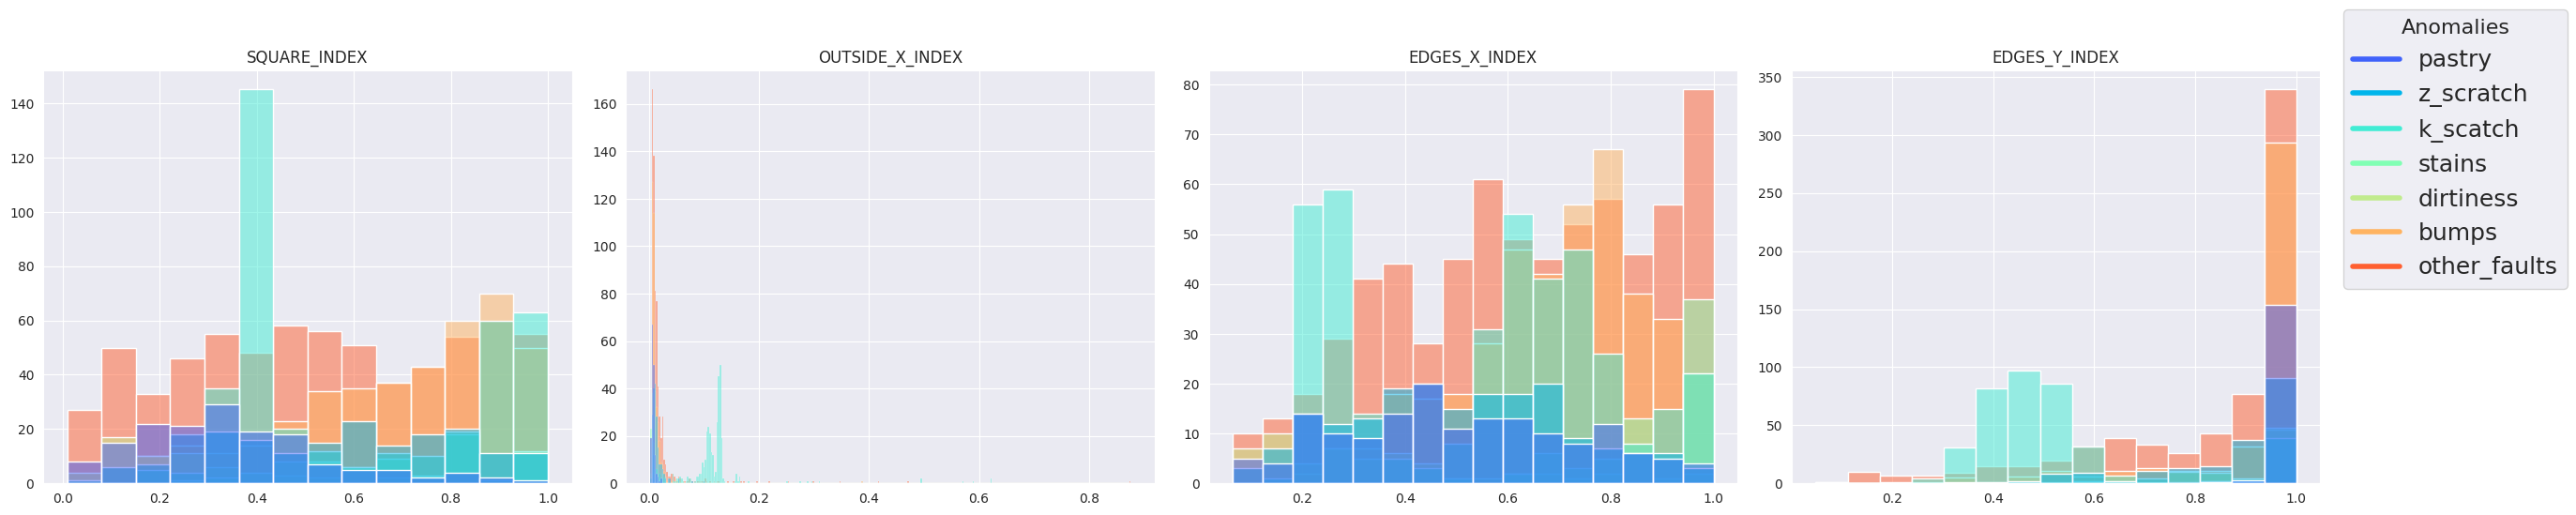

In [16]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

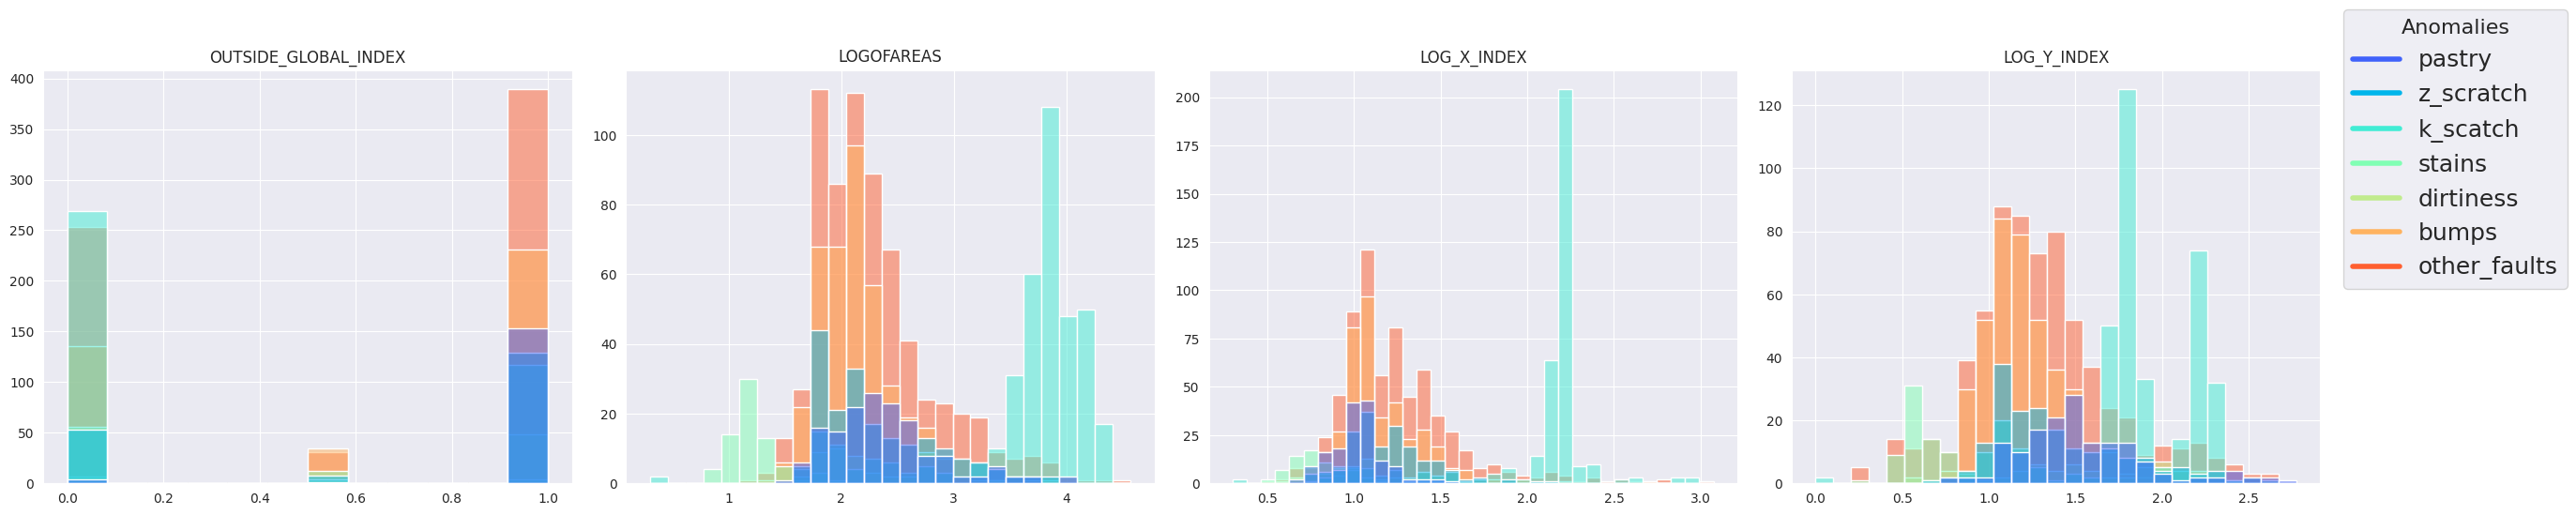

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

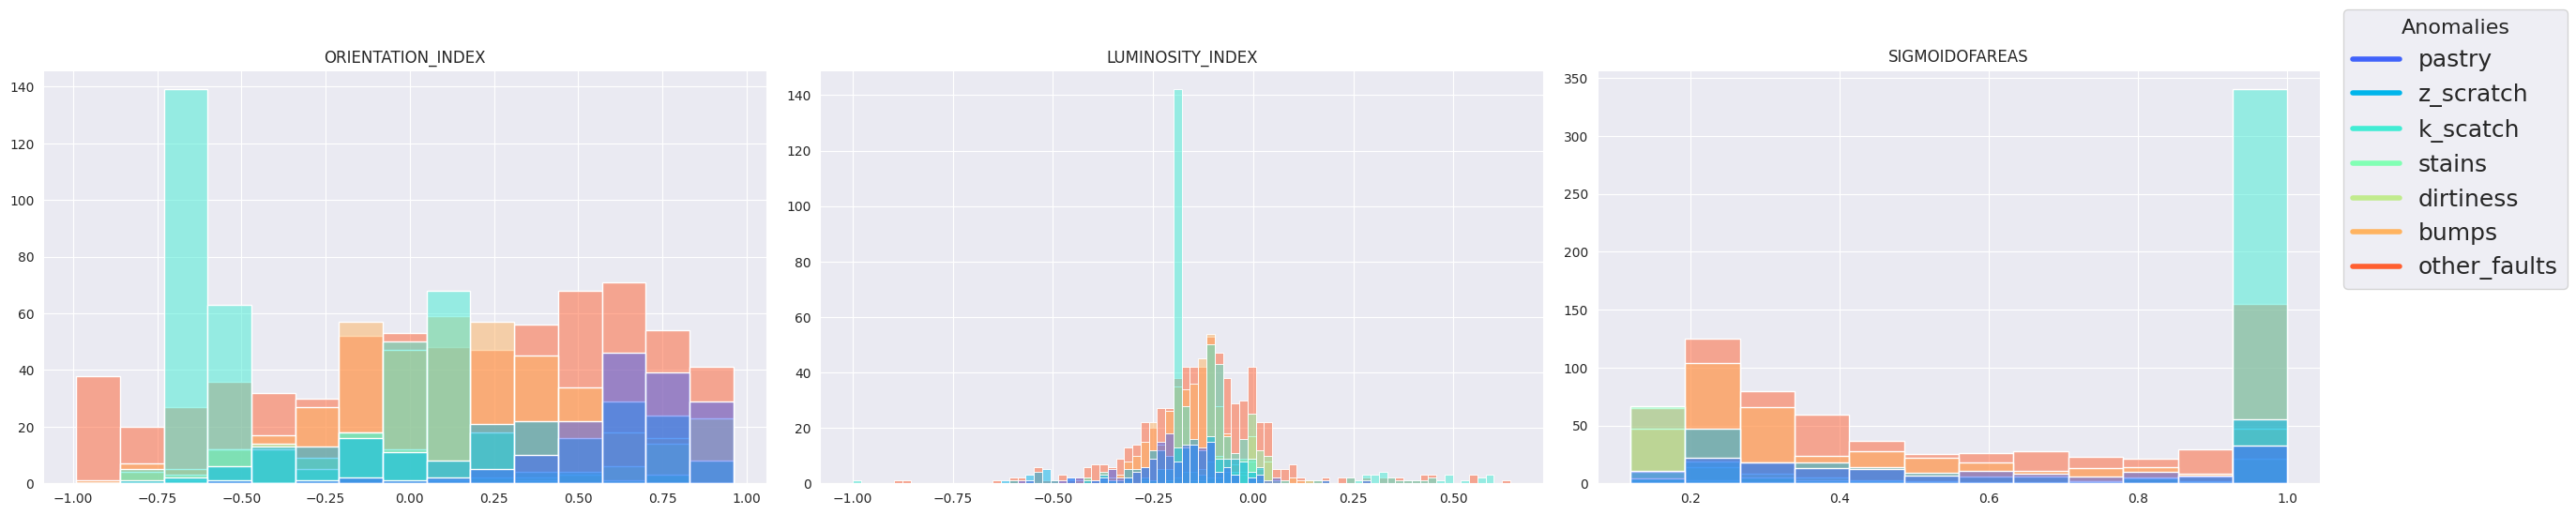

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

## Boxplots of the features

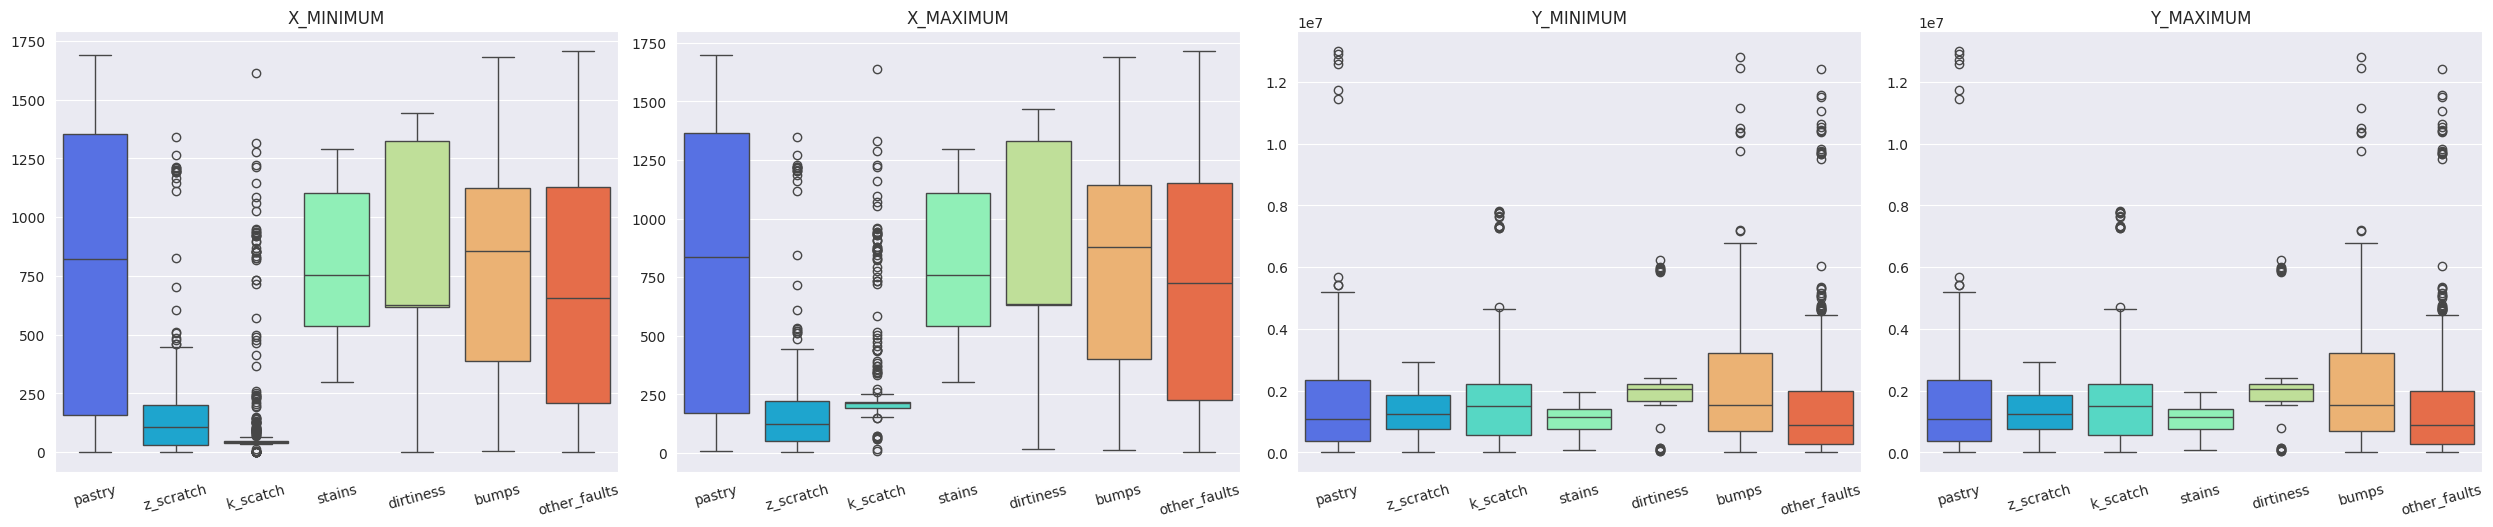

In [19]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[:4]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

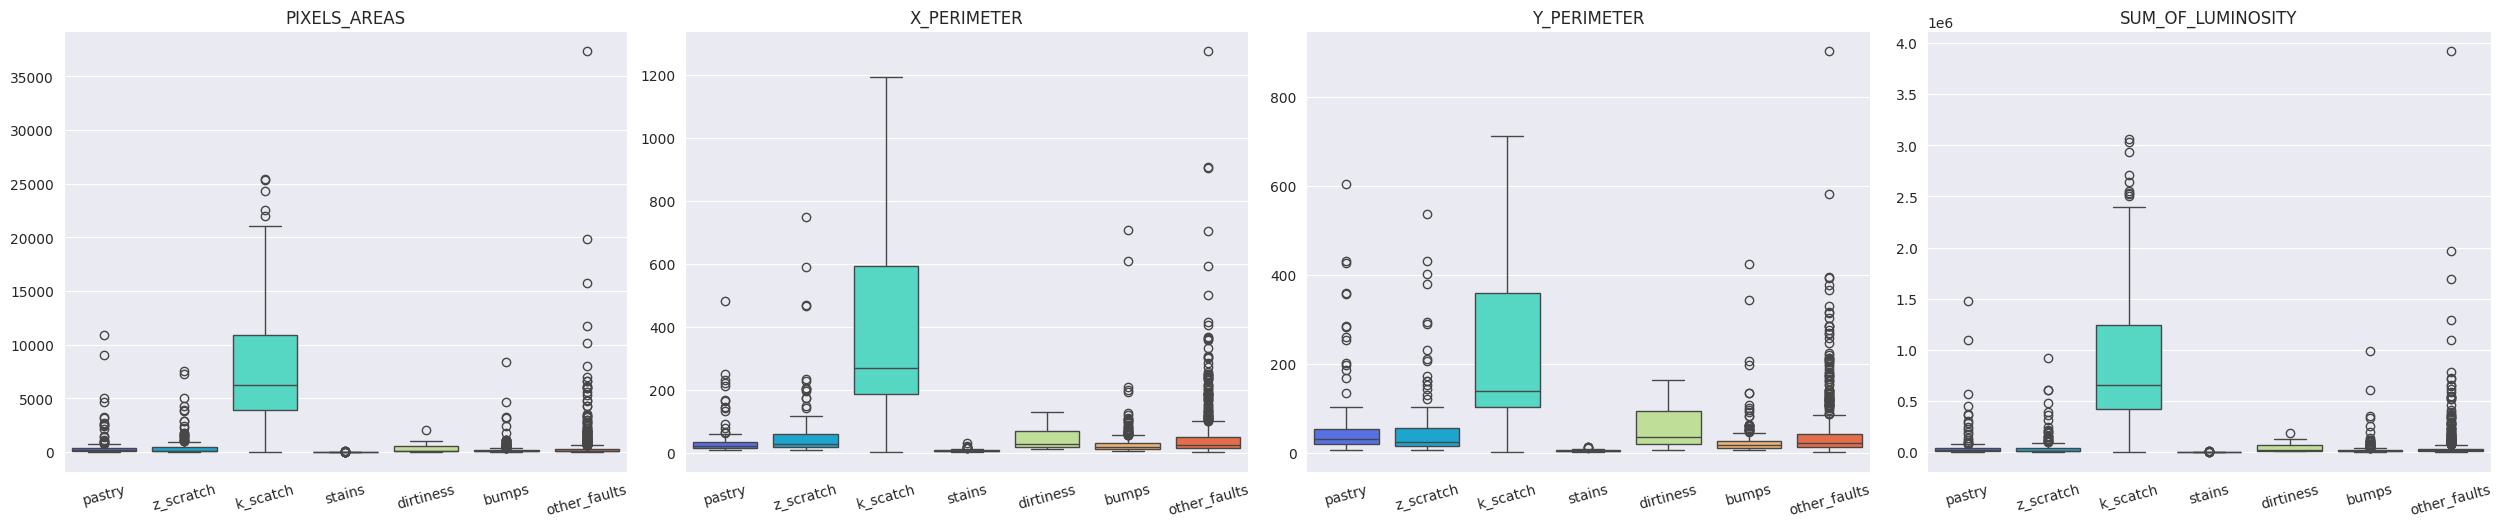

In [20]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

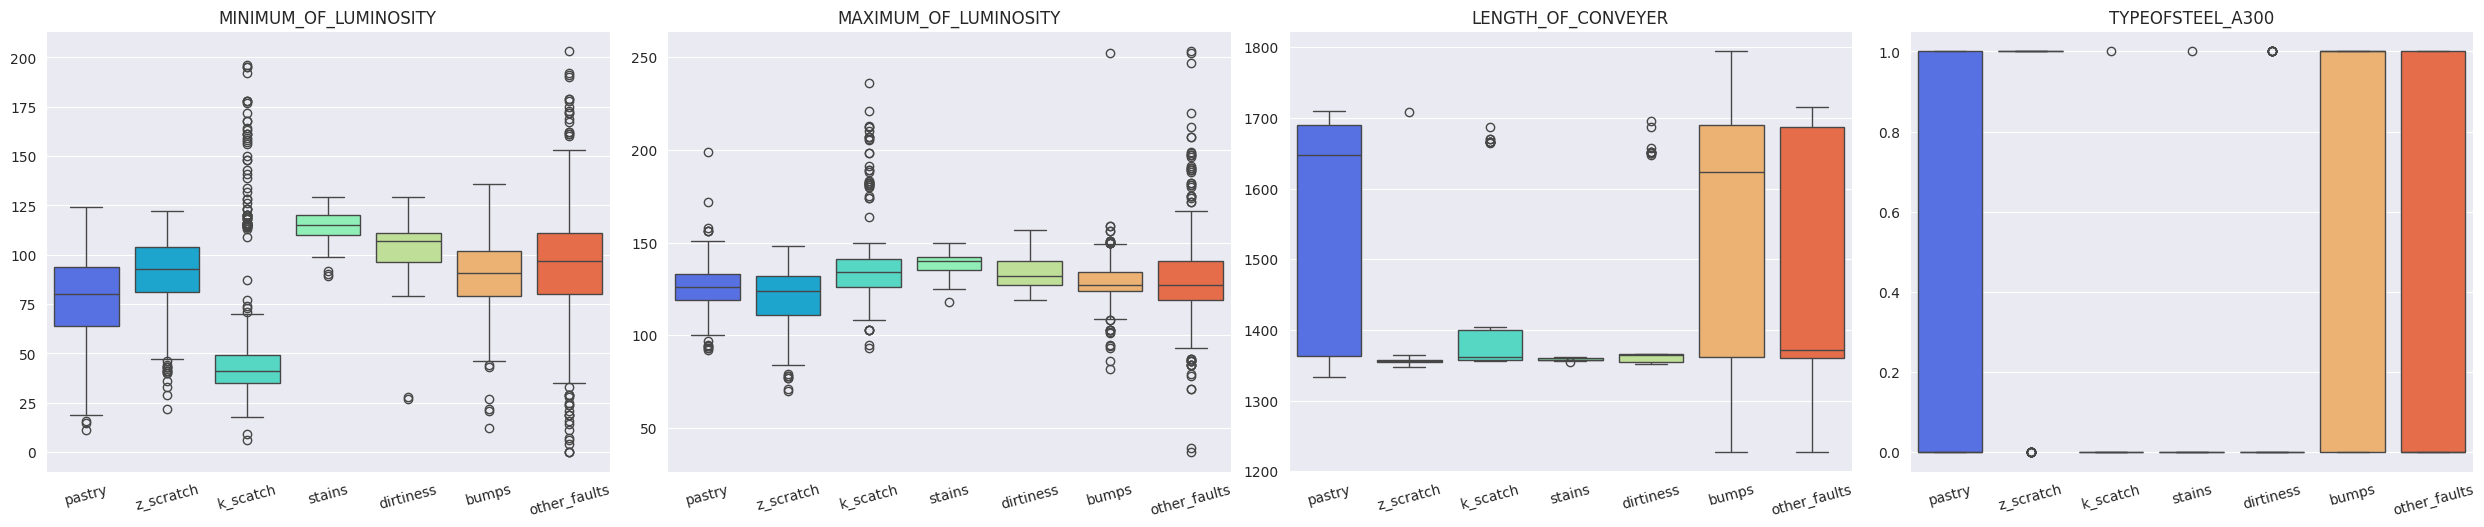

In [21]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

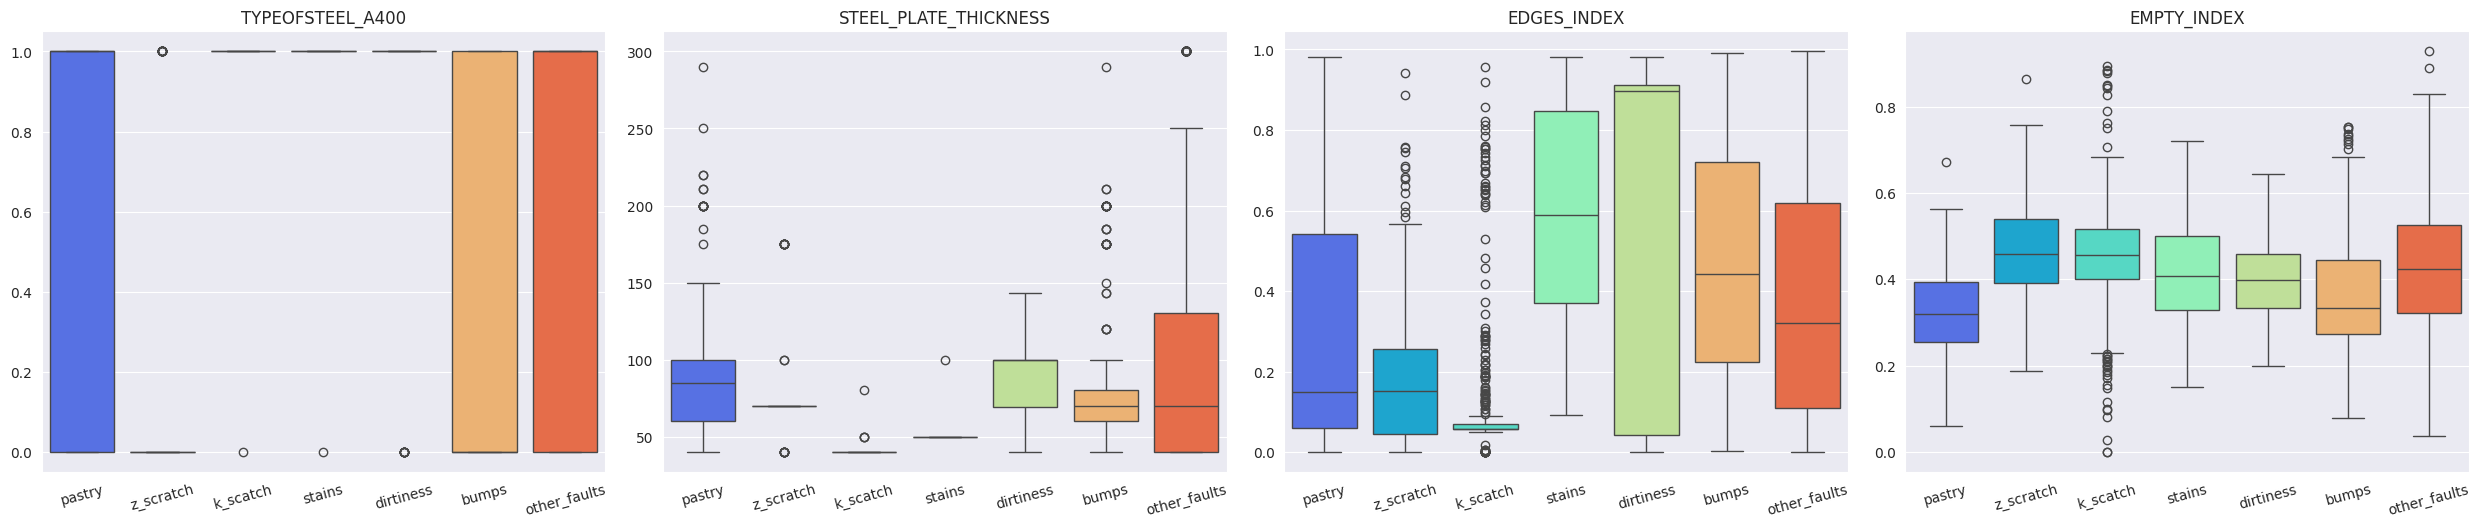

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

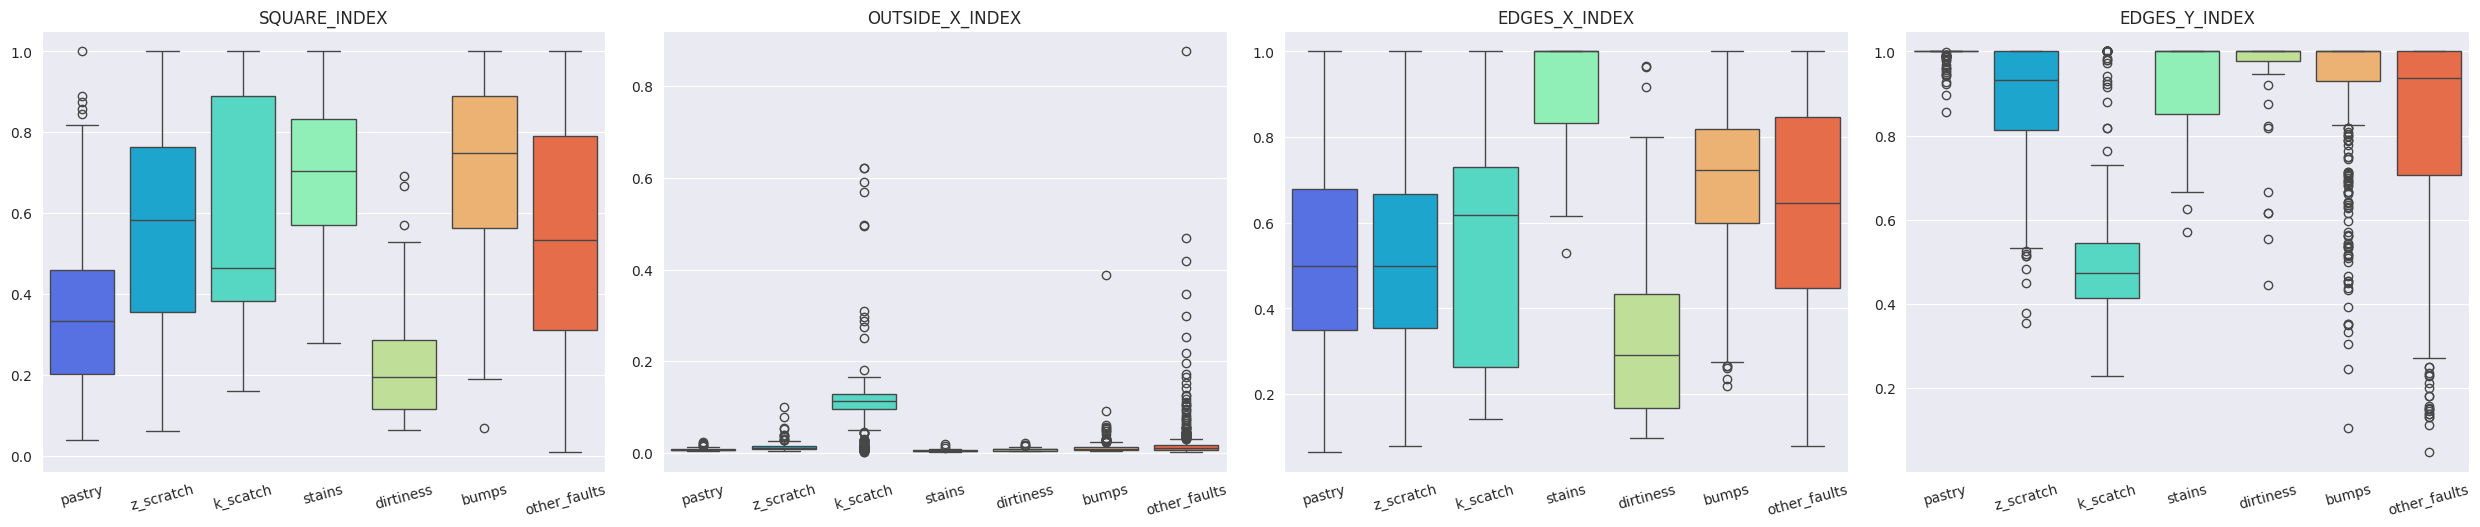

In [23]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

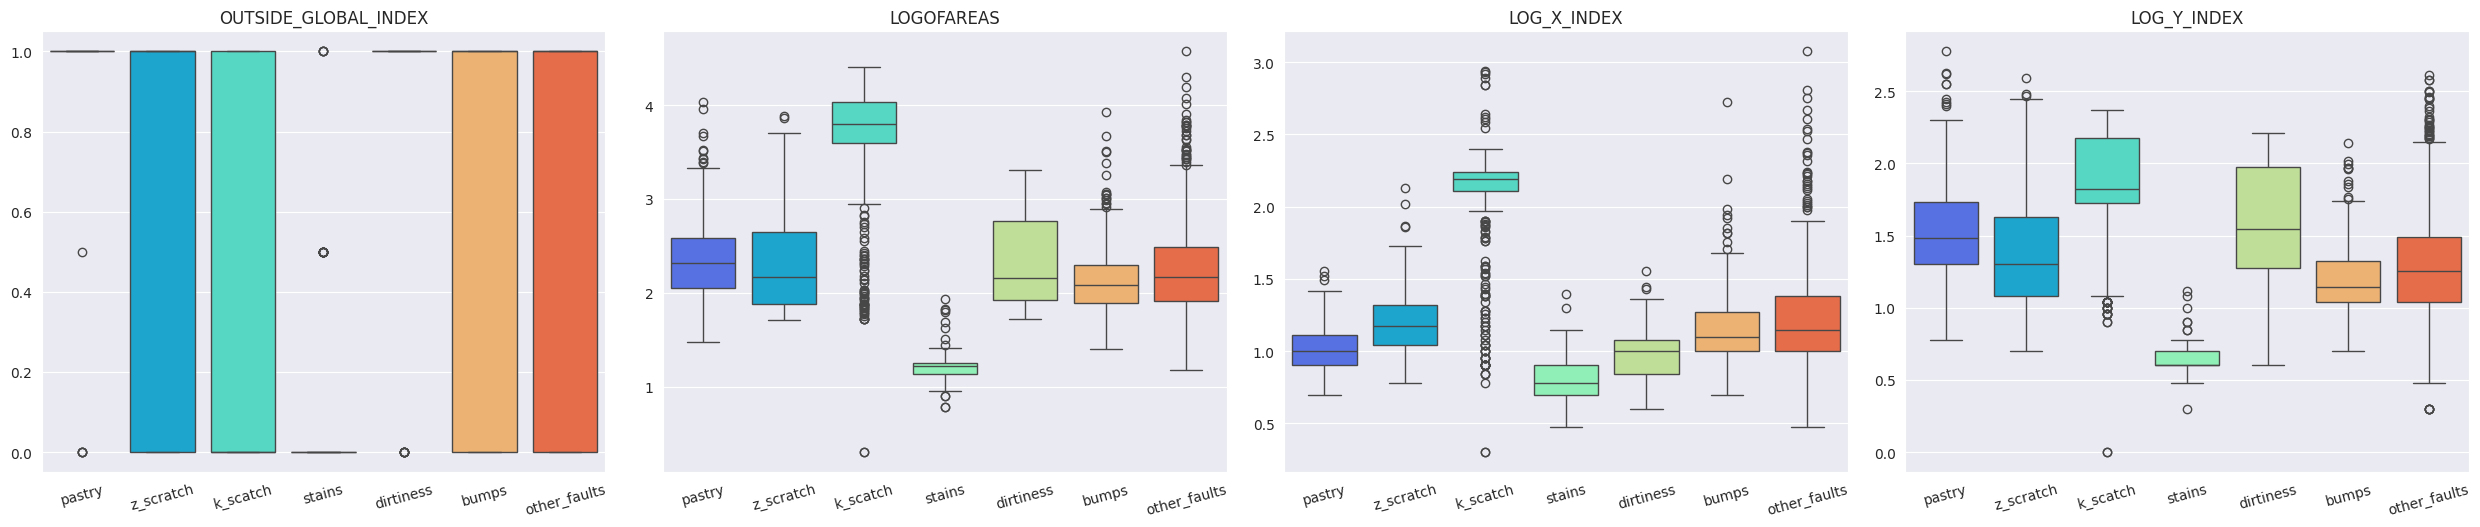

In [24]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

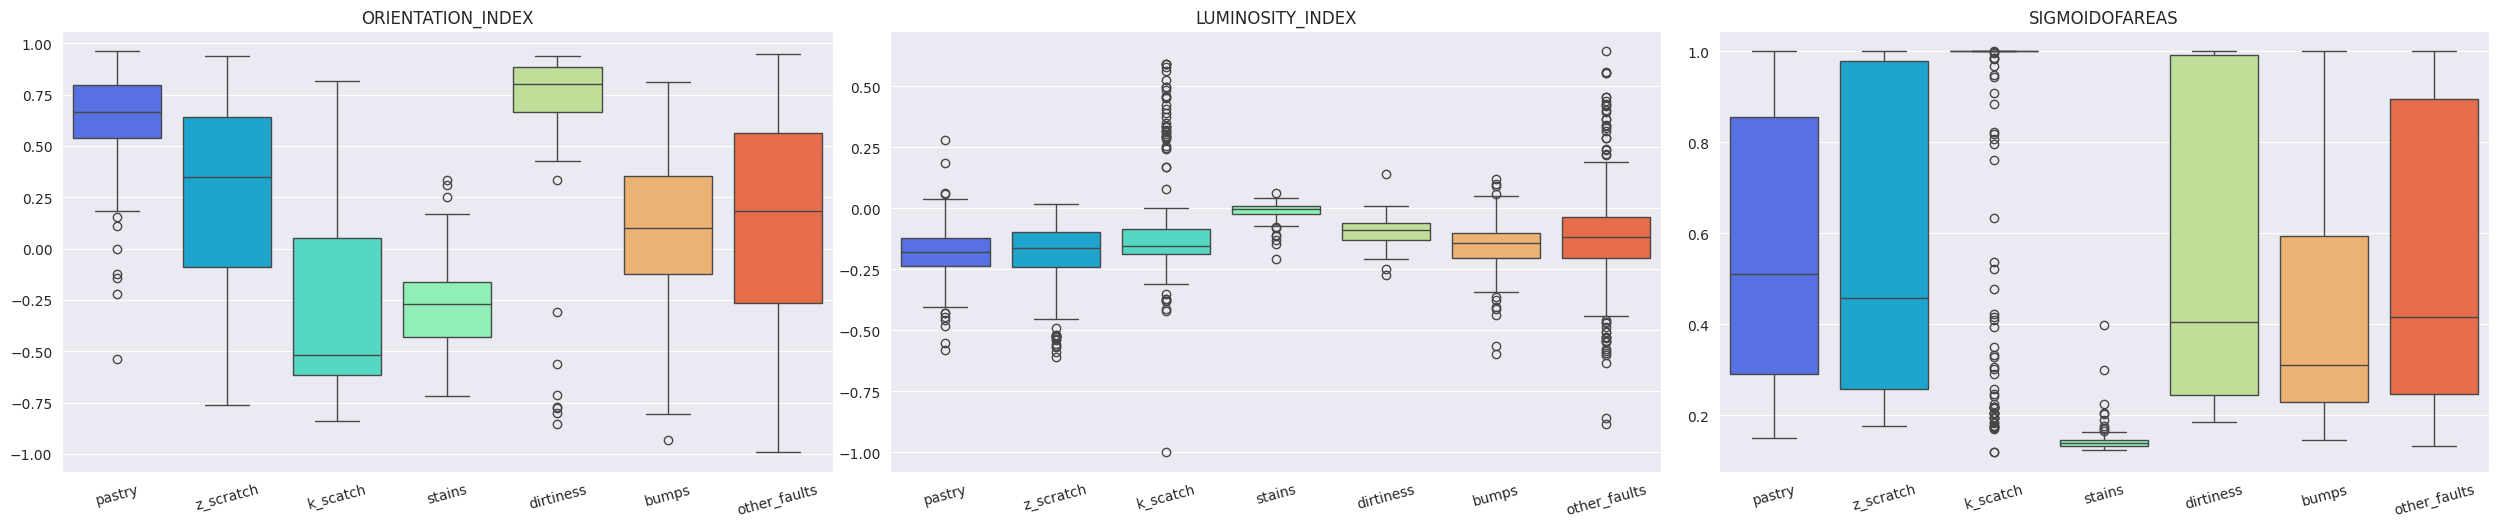

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

Check for binary features

In [26]:
for col in feat_col:
    if len(df[col].unique()) <= 2:
        print(f'Feature {col} has binary data (e.g. 0-1)')

# also check 'outside_global_index' feature
unique_ogi_feature = df['outside_global_index'].unique()
print(f'Feature outside_global_index has {len(unique_ogi_feature)} unique values, which are {str(unique_ogi_feature).strip("[").strip("]")}')

Feature typeofsteel_a300 has binary data (e.g. 0-1)
Feature typeofsteel_a400 has binary data (e.g. 0-1)
Feature outside_global_index has 3 unique values, which are 1.  0.5 0. 


# Outlier detection 

From the boxplots we can clearly see that the dataset seems to present a lot of outliers. Check if these samples need to be removed or not

In [27]:
df_iqr = df.copy()#.drop(target_cols, axis = 1)
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis = 1)]

In [28]:
df_iqr

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,typeofsteel_a300,typeofsteel_a400,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,outside_global_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas,pastry,z_scratch,k_scatch,stains,dirtiness,bumps,other_faults,anomaly
1268,1108,1120,2497122,2497138,137,13,16,15672,85,133,1373,0,1,40,0.3685,0.2865,0.7500,0.0087,0.9231,1.0000,1.0,2.1367,1.0792,1.2041,0.2500,-0.1063,0.3241,0,0,0,0,0,0,1,6
1269,333,342,764107,764213,525,16,106,57020,95,127,1353,0,1,70,0.4922,0.4497,0.0849,0.0066,0.5625,1.0000,1.0,2.7202,0.9542,2.0253,0.9151,-0.1515,0.9872,0,0,0,0,0,0,1,6
1273,1252,1264,1229599,1229628,269,22,29,26745,71,125,1353,0,1,70,0.1316,0.2270,0.4138,0.0089,0.5454,1.0000,1.0,2.4297,1.0792,1.4624,0.5862,-0.2233,0.5757,0,0,0,0,0,0,1,6
1274,1051,1064,1314158,1314195,375,25,37,38401,48,134,1353,0,1,70,0.4272,0.2204,0.3514,0.0096,0.5200,1.0000,1.0,2.5740,1.1139,1.5682,0.6486,-0.2000,0.7670,0,0,0,0,0,0,1,6
1283,662,670,266284,266316,152,25,32,17101,101,125,1630,0,1,120,0.8123,0.4063,0.2500,0.0049,0.3200,1.0000,1.0,2.1818,0.9031,1.5051,0.7500,-0.1210,0.4235,0,0,0,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.3662,0.3906,0.5714,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1,6
1937,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.2118,0.4554,0.5484,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1,6
1938,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.2132,0.3287,0.5172,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1,6
1939,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.2015,0.5904,0.9394,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1,6


In [29]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols

anomaly_count_iqr = pd.DataFrame(df_iqr['anomaly'].value_counts()).sort_index()
#anomaly_count_iqr.index = target_cols
display(anomaly_count_iqr, anomaly_count_iqr - anomaly_count)
lost_samples = round((len(df) - len(df_iqr)) / len(df), 2) * 100
print(f"The dataset lost {lost_samples}% of it's samples")
del df_iqr, anomaly_count_iqr

,count
anomaly,
6,389


,count
6,NaN
bumps,NaN
dirtiness,NaN
k_scatch,NaN
other_faults,NaN
pastry,NaN
stains,NaN
z_scratch,NaN


The dataset lost 80.0% of it's samples


We can see that some anomalies are greatly affected by the IQR outlier deletion. Specifically, k_scratch which was one of the most represented in the dataset, lost 368 samples remaining with only 24. Since we loose a lot of representation, and also because such extreme values of the features specifically for k_scratch might not be casual and our models could theoretically learn this relation, choose to use the datasets without IQR applied. Also, 42% of the dataset would be lost if we applied this outlier detection.

# Correlation between features

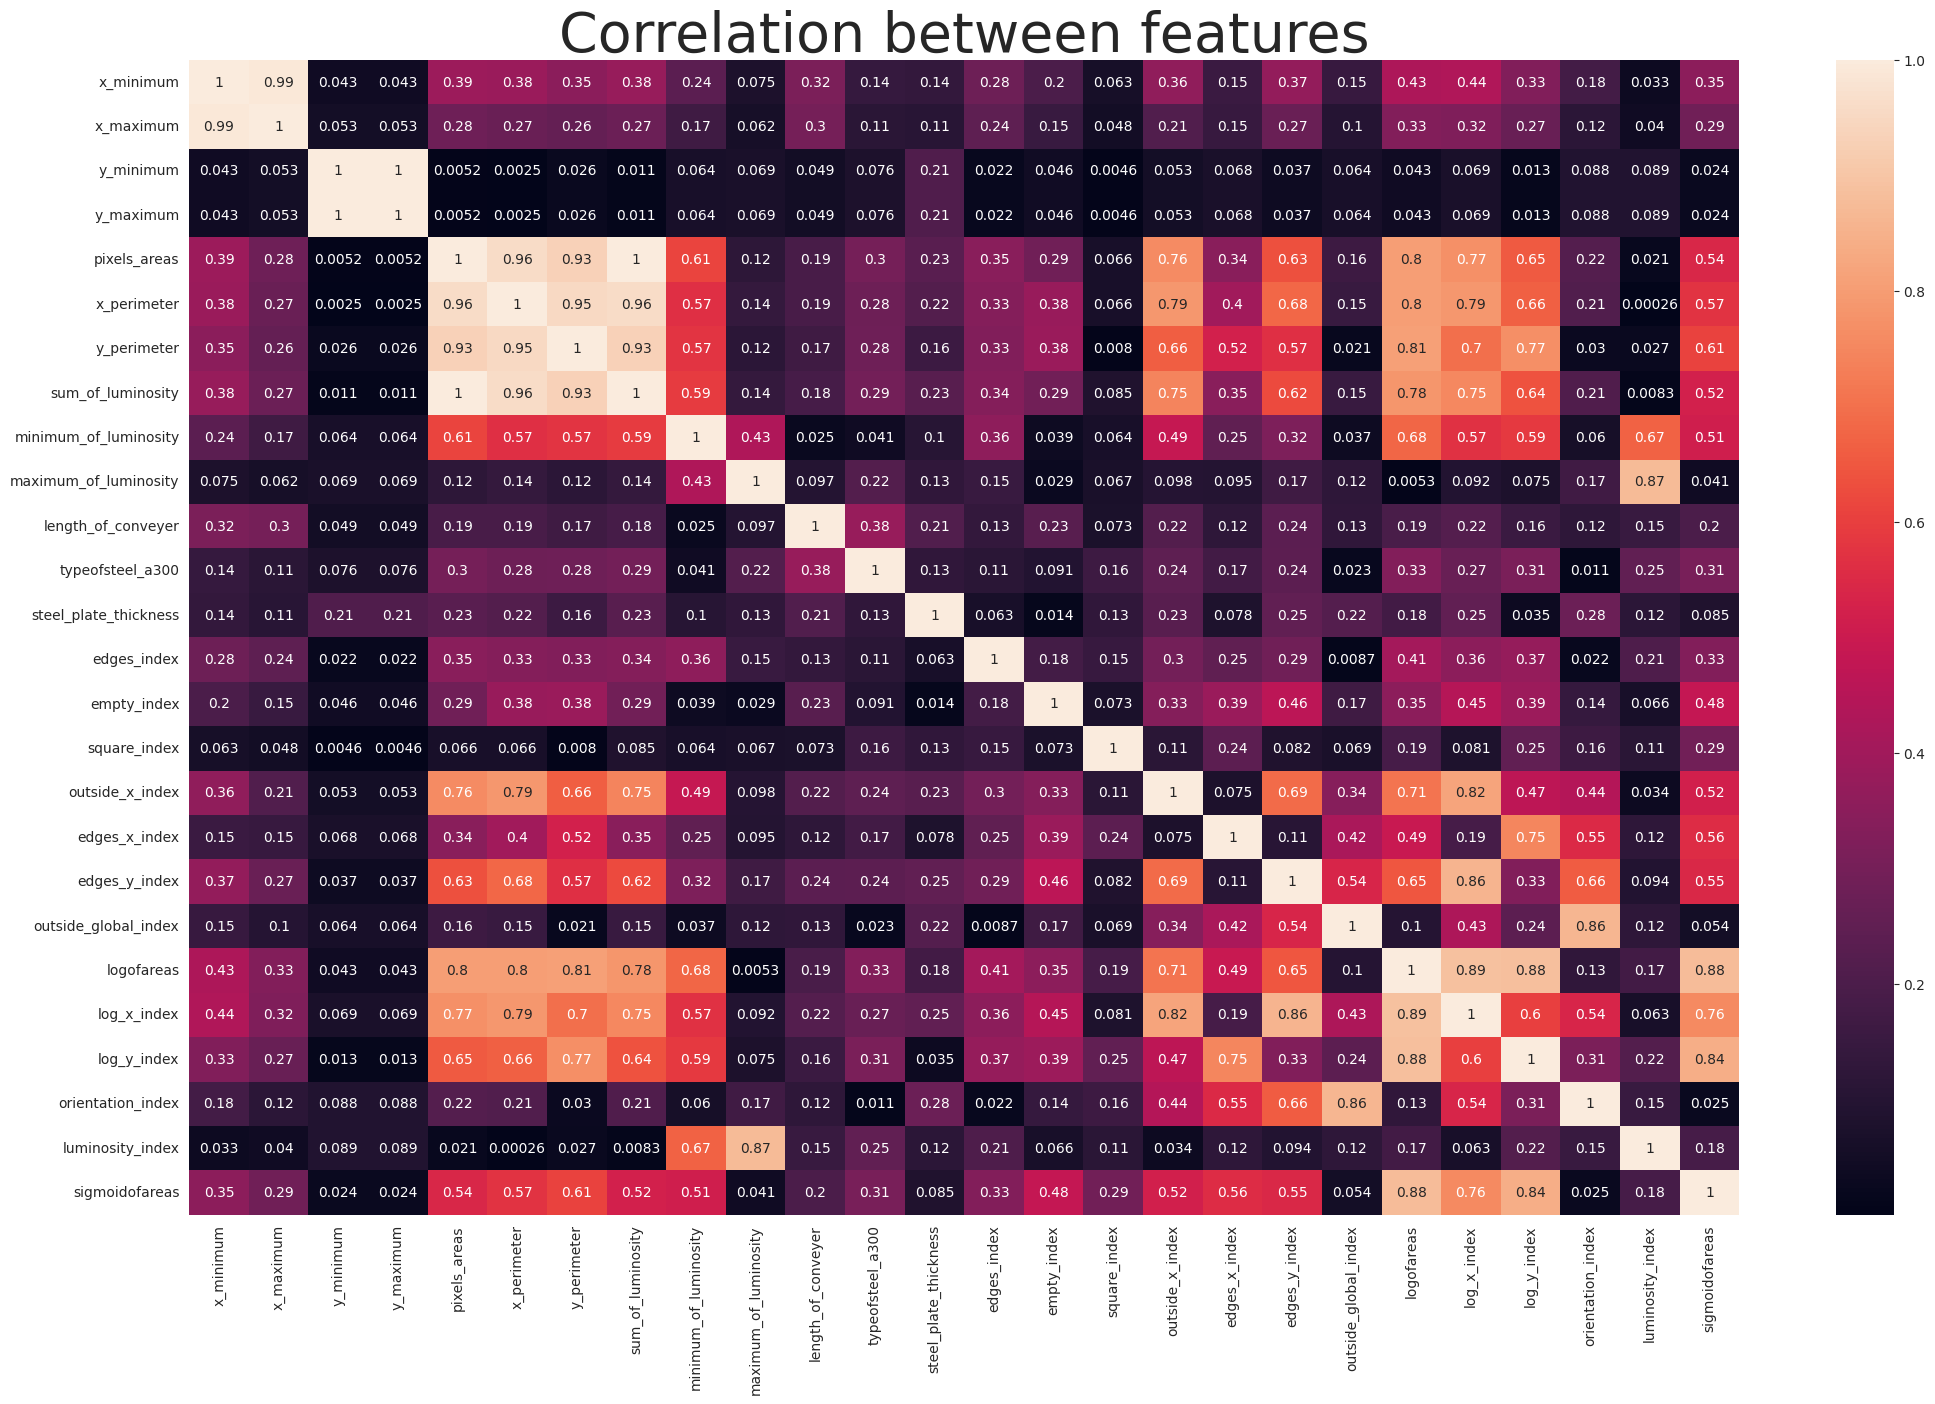

In [30]:
feat_col.remove('typeofsteel_a400')
corr = df[feat_col].corr().abs()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
plt.show()

In [31]:
threshold = 0.7

mask = np.triu(np.ones(corr.shape), k=1)

# Find feature pairs with high correlation
high_corr_pairs = [
    (corr.index[i], corr.columns[j], corr.iloc[i, j])
    for i in range(corr.shape[0])
    for j in range(corr.shape[1])
    if mask[i, j] and corr.iloc[i, j] > threshold
]

high_corr_pairs = pd.DataFrame(high_corr_pairs).T
high_corr_pairs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,x_minimum,y_minimum,pixels_areas,pixels_areas,pixels_areas,pixels_areas,pixels_areas,pixels_areas,x_perimeter,x_perimeter,x_perimeter,x_perimeter,x_perimeter,y_perimeter,y_perimeter,y_perimeter,sum_of_luminosity,sum_of_luminosity,sum_of_luminosity,maximum_of_luminosity,outside_x_index,outside_x_index,edges_x_index,edges_y_index,outside_global_index,logofareas,logofareas,logofareas,log_x_index,log_y_index
1,x_maximum,y_maximum,x_perimeter,y_perimeter,sum_of_luminosity,outside_x_index,logofareas,log_x_index,y_perimeter,sum_of_luminosity,outside_x_index,logofareas,log_x_index,sum_of_luminosity,logofareas,log_y_index,outside_x_index,logofareas,log_x_index,luminosity_index,logofareas,log_x_index,log_y_index,log_x_index,orientation_index,log_x_index,log_y_index,sigmoidofareas,sigmoidofareas,sigmoidofareas
2,0.988314,1.0,0.959504,0.929943,0.996767,0.75919,0.801896,0.770598,0.952089,0.960622,0.787836,0.804662,0.788775,0.9321,0.807914,0.767673,0.745156,0.781953,0.750894,0.87268,0.710946,0.820041,0.749775,0.85694,0.862751,0.889218,0.883591,0.878597,0.757129,0.843182


We see that a lot of our features have high correlations between each others, particularly a lot of features have correlation higher than 0.33 (but even 0.7). This means we could use some feature engineering

Plot some relevant features (Pearson corr > 95%) so that we can better see their correlation

In [32]:
corr[corr > 0.95].replace({1.0 : np.nan}).dropna(how = 'all').dropna(axis = 1, how = 'all')

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity
x_minimum,NaN,0.988314,NaN,NaN,NaN,NaN,NaN,NaN
x_maximum,0.988314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_minimum,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
y_maximum,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
pixels_areas,NaN,NaN,NaN,NaN,NaN,0.959504,NaN,0.996767
x_perimeter,NaN,NaN,NaN,NaN,0.959504,NaN,0.952089,0.960622
y_perimeter,NaN,NaN,NaN,NaN,NaN,0.952089,NaN,NaN
sum_of_luminosity,NaN,NaN,NaN,NaN,0.996767,0.960622,NaN,NaN


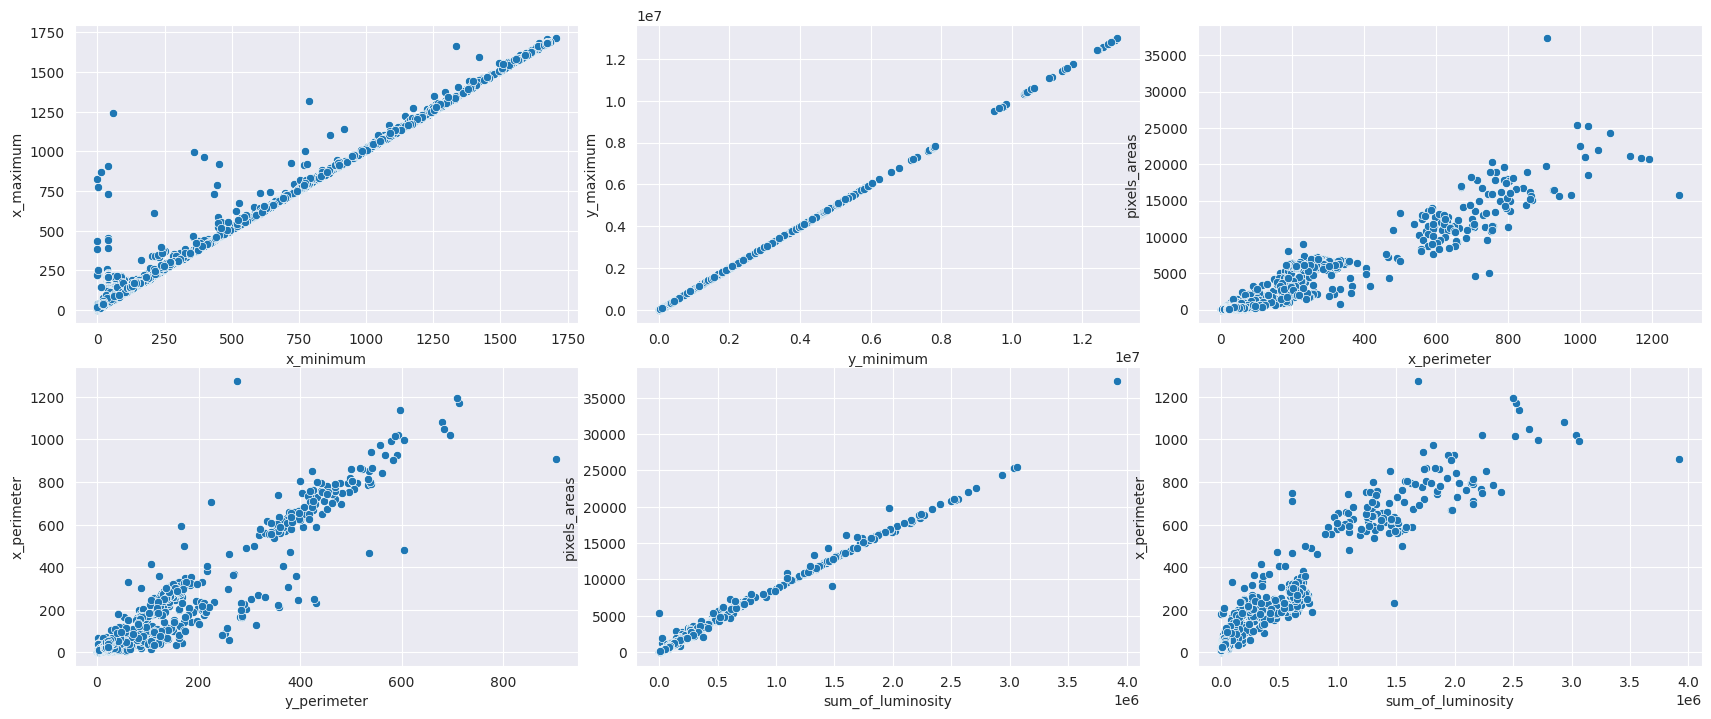

In [33]:
fig, ax = plt.subplots(2, 3, figsize = (17, 7))
plt.tight_layout()
sns.scatterplot(data = df, x = 'x_minimum', y = 'x_maximum', ax = ax[0][0])
sns.scatterplot(data = df, x = 'y_minimum', y = 'y_maximum', ax = ax[0][1])
sns.scatterplot(data = df, x = 'x_perimeter', y = 'pixels_areas', ax = ax[0][2])
sns.scatterplot(data = df, x = 'y_perimeter', y = 'x_perimeter', ax = ax[1][0])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'pixels_areas', ax = ax[1][1])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'x_perimeter', ax = ax[1][2])

plt.show()

We clearly see a strong linearity between the features. Unfortunately, except x_minimum/x_maximum and y_minimum/y_maximum, all the other features are on very different range of data. This means that we can't use simple mean for aggregating some of these features. First, we will need to normalize the data via z-score, and then aggregate some features.

Later in the notebook, dimensionality reduction through UMAP is applied. Since UMAP handles well non-linear relationships, it might not be worth it trying to aggregate all of the highly correlated features. However, we will aggregate the ones displayed in the last graph, since they have almost perfect linear correlation and we will lower the feature dimension, making UMAP more computationally efficient while loosing very little information.

# Balancing the classes/Normalize data

Display how the anomalies are divided in the dataset

In [34]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols
anomaly_count

,count
pastry,158
z_scratch,190
k_scatch,390
stains,72
dirtiness,55
bumps,402
other_faults,673


In [35]:
perc_first_3 = int(anomaly_count.loc[['other_faults', 'bumps', 'k_scatch']].sum()/anomaly_count.sum() * 100)
print(f'The first 3 anomalies count for {perc_first_3}% of the total anomalies')

The first 3 anomalies count for 75% of the total anomalies


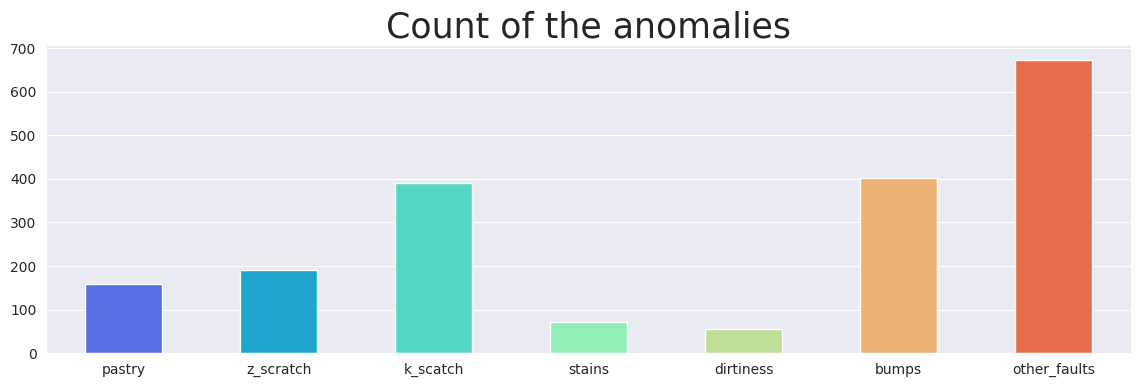

In [36]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count, x = anomaly_count.index, y = 'count', hue = anomaly_count.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

"Modeling Tabular data using Conditional GAN" paper: https://arxiv.org/abs/1907.00503

In [37]:
#df = pd.read_csv('csv/faults.csv')
# Make data more usable
df_processed = ctgan_oversampling.preprocess_df(df)

# Over-sample with SMOTE until all class have at least the same number of samples as the class with the fourth biggest n. of samples
df_smote = ctgan_oversampling.smote_oversampling(df_processed)
print('Anomaly count after oversampling with SMOTE:\n', ctgan_oversampling.sample_count(df_smote), '\n-----------------------------')

# Over-sample with CTGAN, bringing all the classes to 1500 samples
df_over_sampled = ctgan_oversampling.ctgan_oversampling(df_smote, ['typeofsteel_a300', 'outside_global_index', 'anomaly'], 327)

# Normalize old and new synthetic data
df_norm = ctgan_oversampling.scale_df(df_over_sampled, ['typeofsteel_a300', 'outside_global_index', 'anomaly']).sample(frac=1)
df_norm.reset_index(drop=True, inplace=True)

Anomaly count after oversampling with SMOTE:
          count
anomaly       
0.0        190
1.0        190
2.0        389
3.0        190
4.0        190
5.0        402
6.0        673 
-----------------------------
Processing anomaly category: 0.0
Processing anomaly category: 1.0
Processing anomaly category: 2.0
Processing anomaly category: 3.0
Processing anomaly category: 4.0
Processing anomaly category: 5.0
Processing anomaly category: 6.0


In [38]:
anomaly_count_res = pd.DataFrame(df_norm['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

,count
pastry,1000
z_scratch,1000
k_scatch,1000
stains,1000
dirtiness,1000
bumps,1000
other_faults,1000


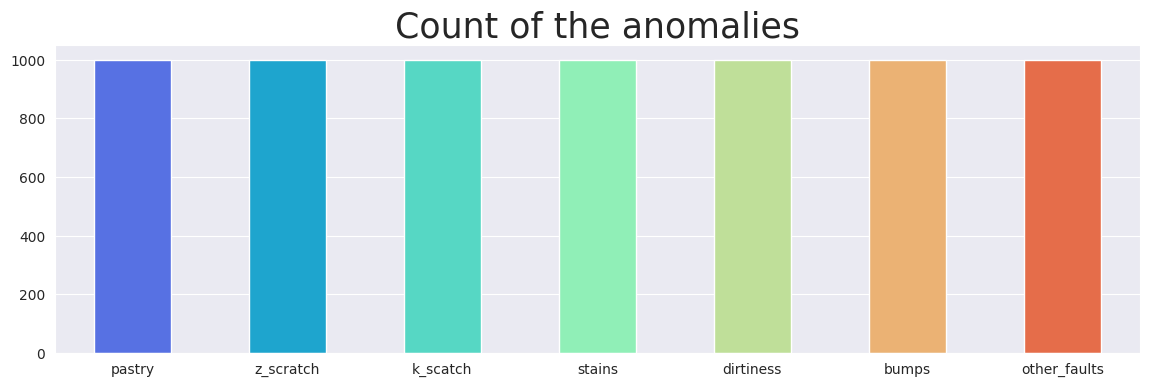

In [39]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count_res, x = anomaly_count_res.index, y = 'count', hue = anomaly_count_res.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [40]:
# check for standardization
norm_dict = {col: [round(df_norm[col].mean()), round(df_norm[col].var())] for col in df_norm.columns}

display(pd.DataFrame(norm_dict, index=['Mean', 'Variance']).drop('anomaly', axis = 1))

,x_minimum,x_maximum,y_minimum,y_maximum,pixels_areas,x_perimeter,y_perimeter,sum_of_luminosity,minimum_of_luminosity,maximum_of_luminosity,length_of_conveyer,steel_plate_thickness,edges_index,empty_index,square_index,outside_x_index,edges_x_index,edges_y_index,logofareas,log_x_index,log_y_index,orientation_index,luminosity_index,sigmoidofareas,typeofsteel_a300,outside_global_index
Mean,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Variance,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1


Data has been correcly standardized since the only features that don't have mean = 0 and variance = 1 are the binary features

# Aggregate features

Aggregate features that have high correlation

In [41]:
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum'], axis = 1, inplace = True)

df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)

df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)

df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)

df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)

df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

# Visualizing the classes

Perform a dimensionality reduction so that we can visualize the classes in a 3 dimensional space.

First try with PCA

In [42]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']

In [43]:
pca = PCA(n_components = 3)  
df_PCA = pca.fit_transform(X)
df_PCA = pd.DataFrame(df_PCA, columns = ['PC1', 'PC2', 'PC3'])
df_PCA['anomaly'] = df_norm['anomaly']

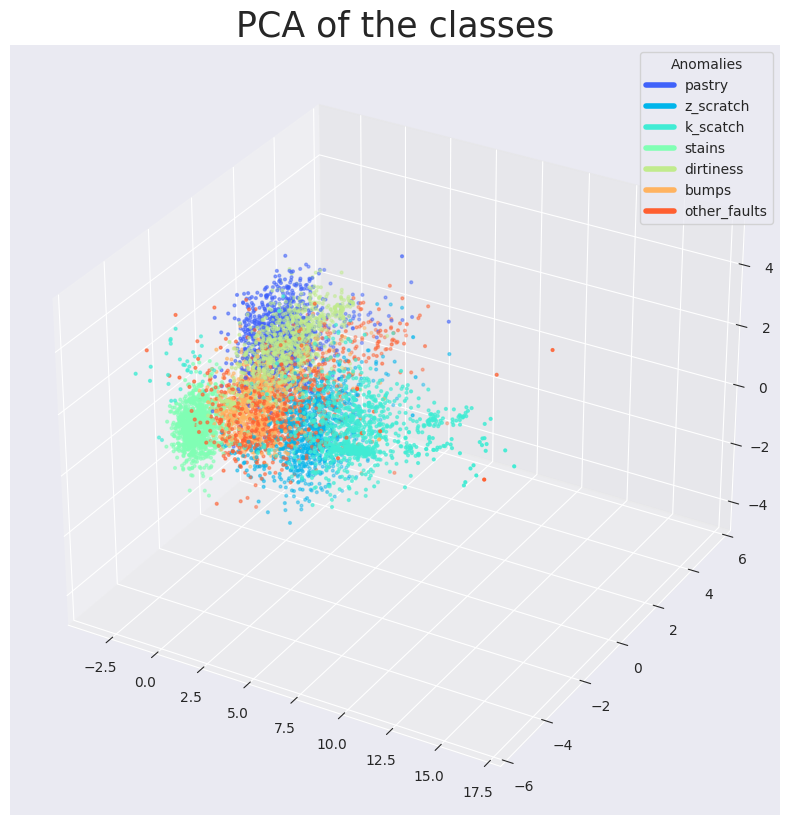

In [44]:
#%matplotlib qtagg 
# uncomment the previous line of code if you want to display interactive plot

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA of the classes', fontsize = 25)
cmap = ListedColormap(palette_hist.as_hex())

ax.scatter(xs = df_PCA['PC1'], ys = df_PCA['PC2'], zs = df_PCA['PC3'], c = df_PCA['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

Seems like PCA doesn't do a great job with this datasets when it comes to visualizing clusters of the classes, perhaps because of the non-linearity of the correlations between the features. 

t-SNE

In [45]:
tsne = TSNE(n_components = 3, random_state = 2)

df_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(df_tsne, columns = ['PC1', 'PC2', 'PC3'])
df_tsne['anomaly'] = df_norm['anomaly']

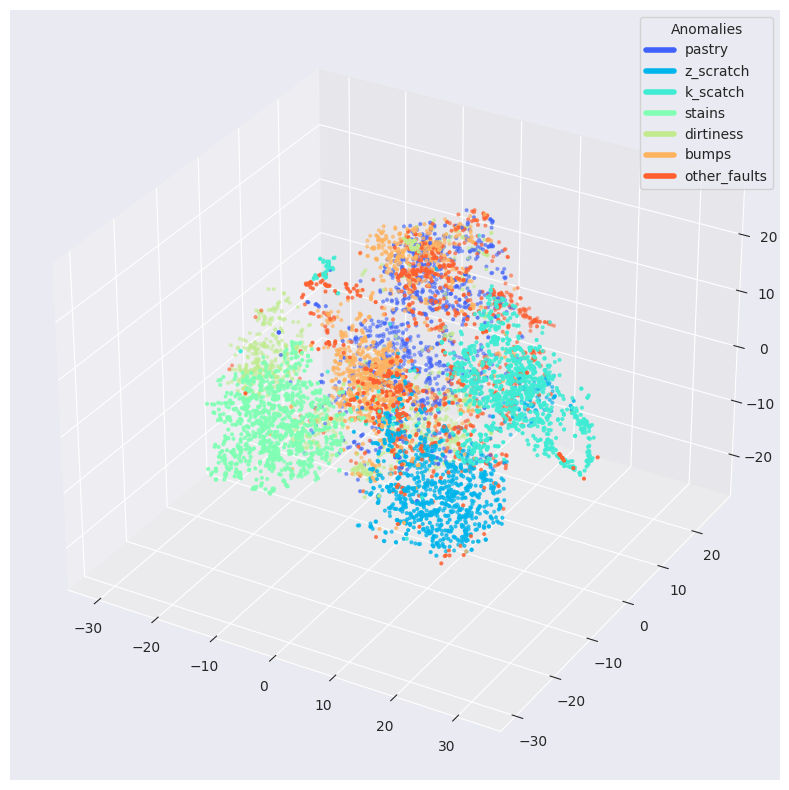

In [46]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')

ax.scatter(df_tsne['PC1'], df_tsne['PC2'], df_tsne['PC3'], c = df_tsne['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP and t-SNE do a better job then PCA when it comes to dimensionality reduction while preserving the clusterization of the different classes. This implies non-linearity in the correlation between the features, and that it might be better to use the UMAP/t-SNE dimensionality reducted dataframes insteand of the original one or the PCA one.

# Models

In [47]:
df_norm = pd.read_csv('csv/balanced_normalized_steel_plates.csv', header = 0, index_col = 0)

In [48]:
metrics_df = pd.DataFrame([], columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_df

,Accuracy,Precision,Recall,F1 Score


## Naive Bayes

### Without preprocessing

In [49]:
gnb = GaussianNB()

In [50]:
X_full = df.drop('anomaly', axis = 1)
y_full = df['anomaly']
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size = 0.3, random_state = 2)

In [51]:
gnb.fit(X_full_train, y_full_train)
y_pred = gnb.predict(X_full_test)

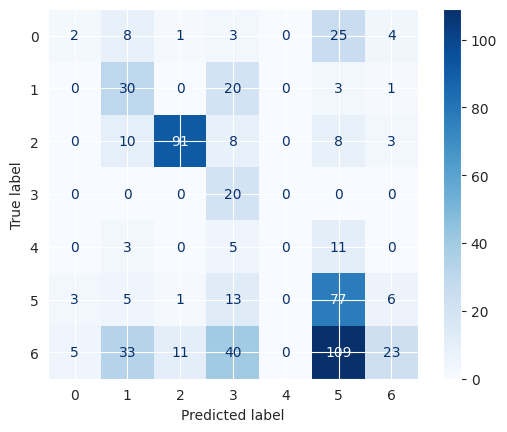

In [52]:
#matplotlib.use('inline')
cm = confusion_matrix(y_full_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
plt.show()

In [53]:
gnb_raw_accuracy = f'{round(accuracy_score(y_full_test, y_pred) * 100, 2)}%'
gnb_raw_precision = f'{round(precision_score(y_full_test, y_pred, average = "macro") * 100, 2)}%'
gnb_raw_recall = f'{round(recall_score(y_full_test, y_pred, average = "macro") * 100, 2)}%'
gnb_raw_f1 = f'{round(f1_score(y_full_test, y_pred, average = "macro") * 100, 2)}%'
print(f'Accuracy score for naive bayes classifier: {gnb_raw_accuracy}')
metrics_df.loc['Raw Gnb'] = [gnb_raw_accuracy, gnb_raw_precision, gnb_raw_recall, gnb_raw_f1]

Accuracy score for naive bayes classifier: 41.75%


In [54]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%


### With preprocessing

In [55]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 83.39%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 83.66%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 85.8%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 82.77%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 84.82%
Accuracy score for naive bayes classifier: 84.43%

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81       199
           1       0.94      0.94      0.94       199
           2       0.98      0.92      0.95       194
           3       0.98      0.98      0.98       190


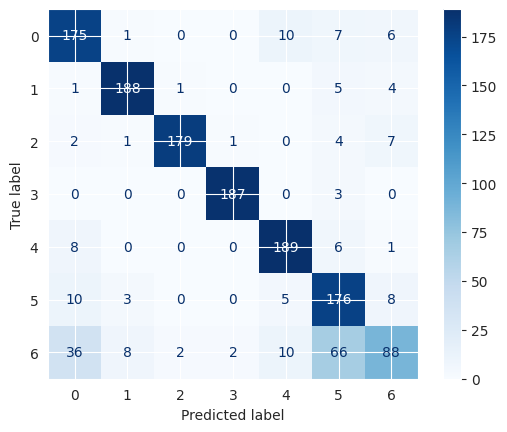

In [56]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):
    gnb = GaussianNB()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    gnb.fit(X.iloc[train], y.iloc[train])
    y_pred = gnb.predict(X.iloc[test])

    accuracy = accuracy_score(gnb.predict(np.array(X.iloc[test])), np.array(y.iloc[test]))
    print(f'Accuracy score for fold {fold_no}: {round(accuracy*100, 2)}%')
    acc_per_fold.append(round(accuracy, 2) * 100)

    if accuracy > best_score:
        best_model = gnb
        best_score = accuracy

    if fold_no == num_splits:
        y_pred = best_model.predict(np.array(X_test))

        gnb_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
        gnb_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        gnb_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        gnb_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for naive bayes classifier: {gnb_accuracy}')
        metrics_df.loc['Gnb'] = [gnb_accuracy, gnb_precision, gnb_recall, gnb_f1]

        print("\nClassification Report:\n", classification_report(y_test, y_pred))


        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
        plt.show()

    fold_no += 1

In [57]:
np.mean(acc_per_fold)

84.2

In [58]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%


As we've seen in the UMAP visualization of the classes, class 5 and 6 are difficultly differentiable. This is confirmed by the the latter confusion matrix. We might try using some hyperparameter tuning/priors/loss balanced learning in the case of the naive bayes classifier

## Support Vector Classifier

### Without parameter hypertuning

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 90.09%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 89.73%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 91.25%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 90.18%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 88.39%
Accuracy score for SVM classifier: 92.07%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       199
           1       0.98      0.95      0.97       199
           2       0.99      0.96      0.97       194
           3       0.98      0.99      0.99       190
       

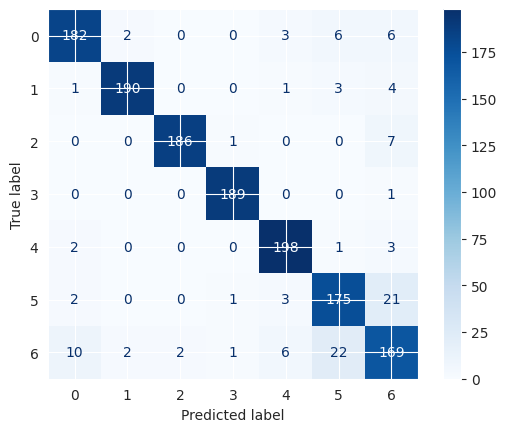

In [59]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):
    svm = SVC()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    svm.fit(X.iloc[train], y.iloc[train])

    accuracy = accuracy_score(svm.predict(np.array(X.iloc[test])), np.array(y.iloc[test]))
    print(f'Accuracy score for fold {fold_no}: {round(accuracy * 100, 2)}%')
    acc_per_fold.append(round(accuracy, 2) * 100)

    if accuracy > best_score:
        best_model = svm
        best_score = accuracy

    if fold_no == num_splits:
        y_pred = best_model.predict(np.array(X_test))

        svm_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
        svm_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        svm_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        svm_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for SVM classifier: {svm_accuracy}')
        metrics_df.loc['SVM'] = [svm_accuracy, svm_precision, svm_recall, svm_f1]

        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
        plt.show()
    fold_no += 1


In [60]:
np.mean(acc_per_fold)

89.8

In [61]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%
SVM,92.07%,92.31%,92.24%,92.26%


### Hyperparameter tuning for SVM

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 89.64%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 89.55%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 90.27%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 90.36%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 90.09%
Accuracy score for SVM classifier: 94.14%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       199
           1       0.98      0.96      0.97       199
           2       0.98      0.97      0.98       194
           3       0.99      0.99      0.99       190
       

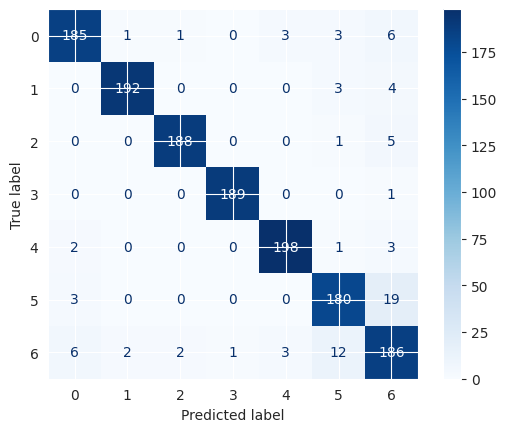

In [62]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold = []
loss_per_fold = []
best_score = 0

parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):
    svc = SVC()
    clf = GridSearchCV(svc, parameters, scoring = 'accuracy', refit = True, verbose = 0)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    clf.fit(X.iloc[train], y.iloc[train])

    accuracy = accuracy_score(clf.predict(np.array(X.iloc[test])), np.array(y.iloc[test]))
    print(f'Accuracy score for fold {fold_no}: {round(accuracy * 100, 2)}%')
    acc_per_fold.append(round(accuracy, 2) * 100)

    if accuracy > best_score:
        best_model = clf
        best_score = accuracy

    if fold_no == num_splits:
        y_pred = best_model.predict(np.array(X_test))

        svm_g_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
        svm_g_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        svm_g_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        svm_g_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for SVM classifier: {svm_g_accuracy}')
        metrics_df.loc['Hyp. Tuning SVM'] = [svm_g_accuracy, svm_g_precision, svm_g_recall, svm_g_f1]

        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
        plt.show()
    fold_no += 1


In [63]:
np.mean(acc_per_fold)

90.0

In [64]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%
SVM,92.07%,92.31%,92.24%,92.26%
Hyp. Tuning SVM,94.14%,94.41%,94.25%,94.31%


## Neural Network Classifier

CHECK https://www.tensorflow.org/tutorials/keras/keras_tuner

2025-02-19 10:47:45.326451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-19 10:47:45.344215: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.3391095697879791; accuracy of 89.91%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.3947076201438904; accuracy of 88.48%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.31101739406585693; accuracy of 89.64%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.29453346133232117; accuracy of 89.91%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.27920281887054443; accuracy of 90.36%
44/44 [==============================] - 0s 1ms/step
Accuracy score for NN classifier: 94.79%

Classification Report:
               precision    recall  f1-score   support

           0 

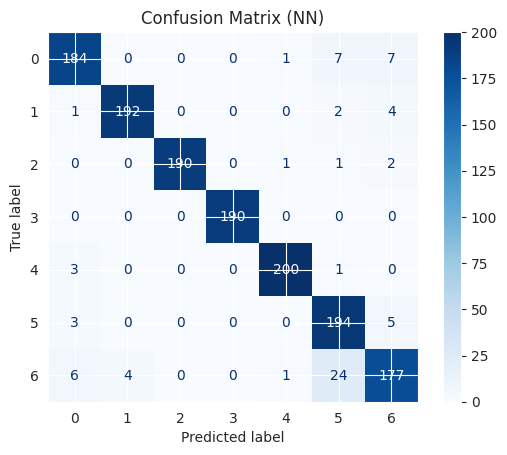

In [65]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):

  # Define the model architecture
  input_layer = Input(shape = (X.shape[1],))
  x = Dense(128, activation=None, kernel_initializer = GlorotNormal())(input_layer)
  x = LeakyReLU(trainable = True)(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation=None, kernel_initializer = GlorotNormal())(x)
  x = LeakyReLU(trainable = True)(x)
  x = Dense(32, activation=None, kernel_initializer = GlorotNormal())(x)
  x = LeakyReLU(trainable = True)(x)
  x = Dense(16, activation=None, kernel_initializer = GlorotNormal())(x)
  x = LeakyReLU(trainable = True)(x)
  output_classification = Dense(7, activation = "softmax", kernel_initializer = GlorotNormal(), name = "classification")(x)
  model = Model(inputs = input_layer, outputs = output_classification)
  model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
   # Fit data to model
  history = model.fit(X.iloc[train], y.iloc[train],
              batch_size = 256,
              epochs = 100,
              verbose = 0)
   # Generate generalization metrics
  scores = model.evaluate(X.iloc[test], y.iloc[test], verbose = 0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {round(scores[1]*100, 2)}%')
  acc_per_fold.append(round(scores[1], 2) * 100)
  loss_per_fold.append(scores[0])
  if scores[1] > best_score:
    best_model = model
    best_score = scores[1]
  
  if fold_no == num_splits:
    y_pred = best_model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    nn_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
    nn_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
    nn_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
    nn_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
    print(f'Accuracy score for NN classifier: {nn_accuracy}')
    metrics_df.loc['FF Neural Network'] = [nn_accuracy, nn_precision, nn_recall, nn_f1]
     # Classification report and confusion matrix
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix (NN)")
    plt.show()
   # Increase fold number
  fold_no = fold_no + 1

In [66]:
np.mean(acc_per_fold)

89.6

In [67]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%
SVM,92.07%,92.31%,92.24%,92.26%
Hyp. Tuning SVM,94.14%,94.41%,94.25%,94.31%
FF Neural Network,94.79%,95.05%,94.92%,94.91%


## Autoencoder classifier

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for NN fold 1: 95.0%
Accuracy score for SVM fold 1: 88.0%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for NN fold 2: 91.0%
Accuracy score for SVM fold 2: 90.0%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for NN fold 3: 95.0%
Accuracy score for SVM fold 3: 89.0%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for NN fold 4: 96.0%
Accuracy score for SVM fold 4: 90.0%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for NN fold 5: 92.0%
Accuracy score for SVM fold 5: 89.0%

Classification Report NN:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       199
           1 

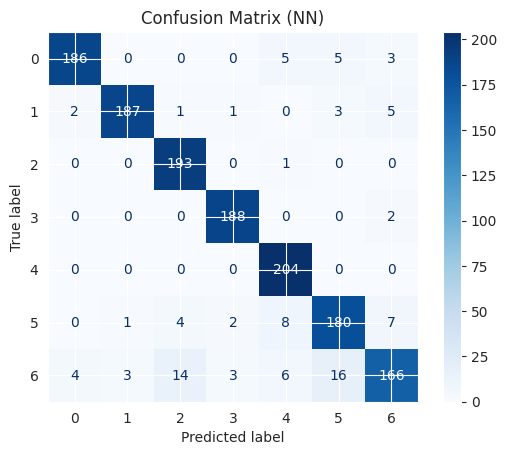


Classification Report SVM:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       199
           1       0.97      0.97      0.97       199
           2       0.99      0.98      0.99       194
           3       0.99      0.99      0.99       190
           4       0.99      0.98      0.98       204
           5       0.91      0.91      0.91       202
           6       0.87      0.91      0.89       212

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400

Accuracy score for Autoencoder SVM classifier: 95.14%, fold n. 2


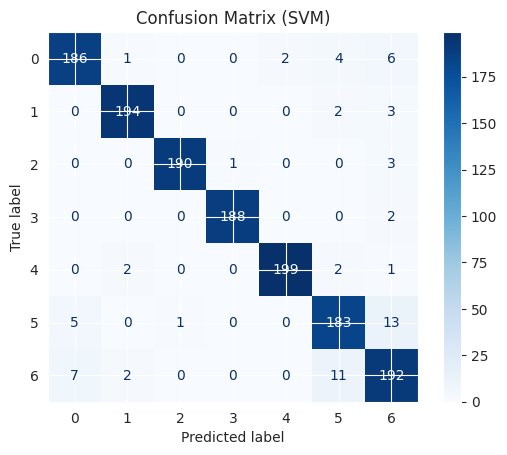

In [68]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True)

sc = StandardScaler()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

acc_per_fold_nn = []
acc_per_fold_svm = []
best_score_nn = 0
best_score_svm = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):
    # Input layer
    input_layer = Input(shape=(X.shape[1],))

    # Encoder: transformation towards latent space
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    x = Dense(15, activation='relu')(encoded)

    # Decoder: data reconstruction
    encoded = Dense(64, activation='relu')(x)
    encoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    output_reconstruction = Dense(X.shape[1], activation = 'relu', name = "reconstruction")(decoded)

    # Classifier: class prediction
    output_classification = Dense(7, activation = 'softmax', name = "classification")(x)

    # Define the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=[output_reconstruction, output_classification])
    classification = Model(inputs = x, outputs = output_classification)

    # Compile the model with a combined loss
    autoencoder.compile(
                        optimizer = 'adam',
                        loss = {
                            "reconstruction": "mse",
                            "classification": 'sparse_categorical_crossentropy'
                        },
                        loss_weights={"reconstruction": 0.5, "classification": 0.5},
                        metrics = ['mse', 'accuracy']
                        )
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = autoencoder.fit(
    X.iloc[train], [X.iloc[train], y.iloc[train]],  # Input: X, Outputs: [reconstruction, classification]
    batch_size = 256,
    epochs = 100,
    shuffle = True,
    validation_split = 0.2,
    verbose = 0
    )

    # Define encoder model to extract latent features
    encoder = Model(inputs = autoencoder.input, outputs = x)

    # Generate latent representations
    latent_features = encoder.predict(X.iloc[train], verbose = 0)
    latent_features_test = encoder.predict(X.iloc[test], verbose = 0)
    latent_features = sc.fit_transform(latent_features)
    latent_features_test = sc.fit_transform(latent_features_test)

    y_pred = classification.predict(latent_features, verbose = 0)
    y_pred = np.argmax(y_pred, axis = 1)

    nn_accuracy = round(accuracy_score(y.iloc[train], y_pred), 2)
    print(f'Accuracy score for NN fold {fold_no}: {round(nn_accuracy * 100, 2)}%')
    acc_per_fold_nn.append(round(nn_accuracy, 2) * 100)

    svm_classifier = SVC()
    grid = GridSearchCV(svm_classifier, param_grid, scoring = 'accuracy', refit = True, verbose = 0)
    grid.fit(latent_features, y.iloc[train])
    y_pred = grid.predict(latent_features_test)

    svm_accuracy = round(accuracy_score(y.iloc[test], y_pred), 2)
    print(f'Accuracy score for SVM fold {fold_no}: {round(svm_accuracy * 100, 2)}%')
    acc_per_fold_svm.append(round(svm_accuracy, 2) * 100)

    if nn_accuracy > best_score_nn:
        best_encoder_nn = encoder
        best_model_nn = classification
        best_score_nn = nn_accuracy
        best_fold_nn = fold_no

    elif svm_accuracy > best_score_svm:
        best_encoder_svm = encoder
        best_model_svm = grid
        best_score_svm = svm_accuracy
        best_fold_svm = fold_no

    if fold_no == num_splits:
        latent_features_nn_test = best_encoder_nn.predict(X_test, verbose = 0)
        latent_features_svm_test = best_encoder_svm.predict(X_test, verbose = 0)
        latent_features_nn_test = sc.fit_transform(latent_features_nn_test)
        latent_features_svm_test = sc.fit_transform(latent_features_svm_test)

        y_pred_nn = best_model_nn.predict(latent_features_nn_test, verbose = 0)
        y_pred_nn = np.argmax(y_pred_nn, axis = 1)

        # Classification report and confusion matrix
        print("\nClassification Report NN:\n", classification_report(y_test, y_pred_nn))

        ae_nn_accuracy = f'{round(accuracy_score(y_test, y_pred_nn) * 100, 2)}%'
        ae_nn_precision = f'{round(precision_score(y_test, y_pred_nn, average = "macro") * 100, 2)}%'
        ae_nn_recall = f'{round(recall_score(y_test, y_pred_nn, average = "macro") * 100, 2)}%'
        ae_nn_f1 = f'{round(f1_score(y_test, y_pred_nn, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for Autoencoder Neural Network classifier: {ae_nn_accuracy}, fold n. {best_fold_nn}')
        metrics_df.loc['AutoEncoder NN Classifier'] = [ae_nn_accuracy, ae_nn_precision, ae_nn_recall, ae_nn_f1]

        cm = confusion_matrix(y_test, y_pred_nn)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(cmap = plt.cm.Blues)
        plt.title("Confusion Matrix (NN)")
        plt.show()

        y_pred_svm = best_model_svm.predict(latent_features_svm_test)
        #y_pred_svm = np.argmax(y_pred_svm, axis = 1)

        print("\nClassification Report SVM:\n", classification_report(y_test, y_pred_svm))

        ae_svm_accuracy = f'{round(accuracy_score(y_test, y_pred_svm) * 100, 2)}%'
        ae_svm_precision = f'{round(precision_score(y_test, y_pred_svm, average = "macro") * 100, 2)}%'
        ae_svm_recall = f'{round(recall_score(y_test, y_pred_svm, average = "macro") * 100, 2)}%'
        ae_svm_f1 = f'{round(f1_score(y_test, y_pred_svm, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for Autoencoder SVM classifier: {ae_svm_accuracy}, fold n. {best_fold_svm}')
        metrics_df.loc['AutoEncoder SVM classifier'] = [ae_svm_accuracy, ae_svm_precision, ae_svm_recall, ae_svm_f1]

        cm = confusion_matrix(y_test, y_pred_svm)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(cmap = plt.cm.Blues)
        plt.title("Confusion Matrix (SVM)")
        plt.show()

    fold_no = fold_no + 1

In [69]:
print(np.mean(acc_per_fold_nn))
print(np.mean(acc_per_fold_svm))

93.8
89.2


In [70]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%
SVM,92.07%,92.31%,92.24%,92.26%
Hyp. Tuning SVM,94.14%,94.41%,94.25%,94.31%
FF Neural Network,94.79%,95.05%,94.92%,94.91%
AutoEncoder NN Classifier,93.14%,93.25%,93.33%,93.15%
AutoEncoder SVM classifier,95.14%,95.32%,95.22%,95.26%


## TabNet

"TabNet: Attentive Interpretable Tabular Learning" paper: https://arxiv.org/abs/1908.07442

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 88.57%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 89.82%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 87.95%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 88.3%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 87.32%
Accuracy score for TabNet classifier: 92.36%

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       199
           1       0.98      0.93      0.95       199
           2       0.98      0.96      0.97       194
           3       1.00      1.00      1.00       190
     

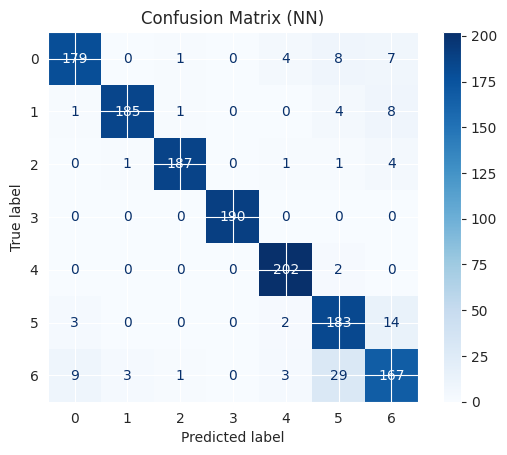

In [71]:
num_splits = 5
k_fold = KFold(n_splits = num_splits)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model = TabNetClassifier()
    # Suppress TabNet's print output
    with contextlib.redirect_stdout(io.StringIO()):
        model.fit(
                np.array(X.iloc[train]), np.array(y.iloc[train]),
                max_epochs=200,
                eval_set=[(np.array(X.iloc[test]), np.array(y.iloc[test]))],
                patience=30,
                batch_size=256
            )
    accuracy = accuracy_score(model.predict(np.array(X.iloc[test])), np.array(y.iloc[test]))
    print(f'Accuracy score for fold {fold_no}: {round(accuracy*100, 2)}%')
    acc_per_fold.append(round(accuracy * 100, 2))

    if accuracy > best_score:
        best_model = model
        best_score = accuracy
    
    if fold_no == num_splits:
        y_pred = best_model.predict(np.array(X_test))
    
        nn_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
        nn_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        nn_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        nn_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for TabNet classifier: {nn_accuracy}')
        metrics_df.loc['TabNet'] = [nn_accuracy, nn_precision, nn_recall, nn_f1]
    
        # Classification report and confusion matrix
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
    
        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(cmap = plt.cm.Blues)
        plt.title("Confusion Matrix (NN)")
        plt.show()
    fold_no = fold_no + 1

In [72]:
np.mean(acc_per_fold)

88.392

In [73]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%
SVM,92.07%,92.31%,92.24%,92.26%
Hyp. Tuning SVM,94.14%,94.41%,94.25%,94.31%
FF Neural Network,94.79%,95.05%,94.92%,94.91%
AutoEncoder NN Classifier,93.14%,93.25%,93.33%,93.15%
AutoEncoder SVM classifier,95.14%,95.32%,95.22%,95.26%
TabNet,92.36%,92.7%,92.53%,92.54%


## FTTransformer

"Revisiting Deep Learning Models for Tabular Data" paper: https://arxiv.org/abs/2106.11959

![Alt Text](https://www.researchgate.net/publication/372985818/figure/fig1/AS:11431281180233791@1691514218219/The-FT-Transformer-architecture-the-proposed-architecture-contains-two-major-blocks.png)

------------------------------------------------------------------------
Training for fold 1 ...


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Accuracy score for fold 1: 89.29%
------------------------------------------------------------------------
Training for fold 2 ...


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Accuracy score for fold 2: 90.29%
------------------------------------------------------------------------
Training for fold 3 ...


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Accuracy score for fold 3: 90.85%
------------------------------------------------------------------------
Training for fold 4 ...


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Accuracy score for fold 4: 89.84%
------------------------------------------------------------------------
Training for fold 5 ...


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Accuracy score for fold 5: 88.5%
-----------------------------------
Accuracy score for FTTransformer classifier: 94.79%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       199
           1       0.97      0.98      0.98       199
           2       0.99      0.99      0.99       194
           3       0.99      1.00      0.99       190
           4       0.99      0.93      0.96       204
           5       0.90      0.93      0.91       202
           6       0.90      0.85      0.87       212

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400



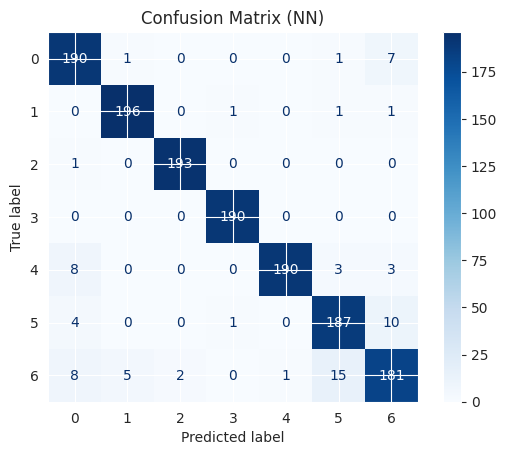

In [74]:
num_splits = 5
k_fold = KFold(n_splits = num_splits)

acc_per_fold = []
loss_per_fold = []
best_score = 0

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_train, y_train):
    df_temp = pd.concat([X.iloc[train], y.iloc[train]], ignore_index = True, axis = 1)
    df_temp.columns = df_norm.columns
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    device = fttransformer.create_device()

    X_num_train, X_num_test, X_cat_train, X_cat_test, y_train1, y_test1 = fttransformer.create_tensors(df_temp, 'anomaly', ['typeofsteel_a300', 'outside_global_index'], device)

    train_loader = fttransformer.create_dataloader(512, X_num_train, X_cat_train, y_train1)

    cardinalities = fttransformer.get_cardinalities(X_cat_train)

    model, optimizer, loss_fn = fttransformer.compile_transformer(X_num_train.shape[1], cardinalities, 7, device)

    model = fttransformer.train_transformer(model, optimizer, loss_fn, epochs=50, train_loader=train_loader, device=device)

    y_pred = fttransformer.get_prediction(model, X_num_test, X_cat_test)
    accuracy = fttransformer.accuracy_ftt(y_test1, y_pred)

    print(f'Accuracy score for fold {fold_no}: {accuracy}%')
    acc_per_fold.append(accuracy)

    if accuracy > best_score:
        best_model = model
        best_score = accuracy

    if fold_no == num_splits:
        print('-----------------------------------')
        device = fttransformer.create_device()

        X_num_test = X_test.drop(['typeofsteel_a300', 'outside_global_index'], axis = 1)
        X_cat_test = X_test[['typeofsteel_a300', 'outside_global_index']]

        X_num_test, X_cat_test = X_num_test.to_numpy(dtype=np.float32), X_cat_test.to_numpy(dtype=np.int64)
        X_num_test, X_cat_test = map(torch.tensor, (X_num_test, X_cat_test))
        X_num_test, X_cat_test = X_num_test.to(device), X_cat_test.to(device)

        y_pred = fttransformer.get_prediction(best_model, X_num_test, X_cat_test)
        y_pred = y_pred.cpu().numpy()

        nn_accuracy = f'{round(accuracy_score(y_test, y_pred) * 100, 2)}%'
        nn_precision = f'{round(precision_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        nn_recall = f'{round(recall_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        nn_f1 = f'{round(f1_score(y_test, y_pred, average = "macro") * 100, 2)}%'
        print(f'Accuracy score for FTTransformer classifier: {nn_accuracy}')
        metrics_df.loc['FTTransformer'] = [nn_accuracy, nn_precision, nn_recall, nn_f1]

        # Classification report and confusion matrix
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)

        disp = ConfusionMatrixDisplay(confusion_matrix = cm)
        disp.plot(cmap = plt.cm.Blues)
        plt.title("Confusion Matrix (NN)")
        plt.show()

    fold_no = fold_no + 1


In [75]:
np.mean(acc_per_fold)

89.75399999999999

In [76]:
metrics_df

,Accuracy,Precision,Recall,F1 Score
Raw Gnb,41.75%,36.4%,45.68%,32.16%
Gnb,84.43%,85.31%,84.91%,84.04%
SVM,92.07%,92.31%,92.24%,92.26%
Hyp. Tuning SVM,94.14%,94.41%,94.25%,94.31%
FF Neural Network,94.79%,95.05%,94.92%,94.91%
AutoEncoder NN Classifier,93.14%,93.25%,93.33%,93.15%
AutoEncoder SVM classifier,95.14%,95.32%,95.22%,95.26%
TabNet,92.36%,92.7%,92.53%,92.54%
FTTransformer,94.79%,94.92%,94.93%,94.89%


In [77]:
# TO-DO
# TODO: hyp tuning NN
# TODO: cv metrics df with all the mean of the various metrics during cross validation (more accurate way to validate the models and pick the best one)

# IDEAS
- feat eng polynomial features, 
- Apply transformations like log, sqrt, or Box-Cox for skewed features